Notebook purpose

- Sense-check and explore calculated account balances

In [2]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [51]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
df.head(1)

id       date  user_id  amount                            desc  \
0  3631012 2013-01-07    17277    7.27  tesco stores 5051 <mdbremoved>   

  merchant          tag user_female user_postcode user_registration_date  \
0    tesco  supermarket       False        ox10 9             2013-02-10   

  user_salary_range  user_yob account_created  account_id  \
0               NaN    1974.0      2013-02-11      230282   

  account_last_refreshed account_provider account_type  \
0    2015-05-21 06:47:00     virgin money  credit card   

  data_warehouse_date_created data_warehouse_date_last_updated  debit  \
0                  2014-07-18                       2017-08-14   True   

   latest_balance merchant_business_line                    tag_auto  \
0             NaN      tesco supermarket  food, groceries, household   

  tag_manual       tag_up      ym  balance  
0        NaN  supermarket  201301      NaN

## Savings account balances

In [52]:
df.groupby('account_id').account_type.first().value_counts()

current        99
savings        60
credit card    30
other           5
Name: account_type, dtype: int64

In [58]:
daily_balances = (df[df.account_type == 'savings']
                  .set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .assign(account_label=lambda x: 
                          x.account_id.astype('str') + '-' 
                          + x.user_id.astype('str')))

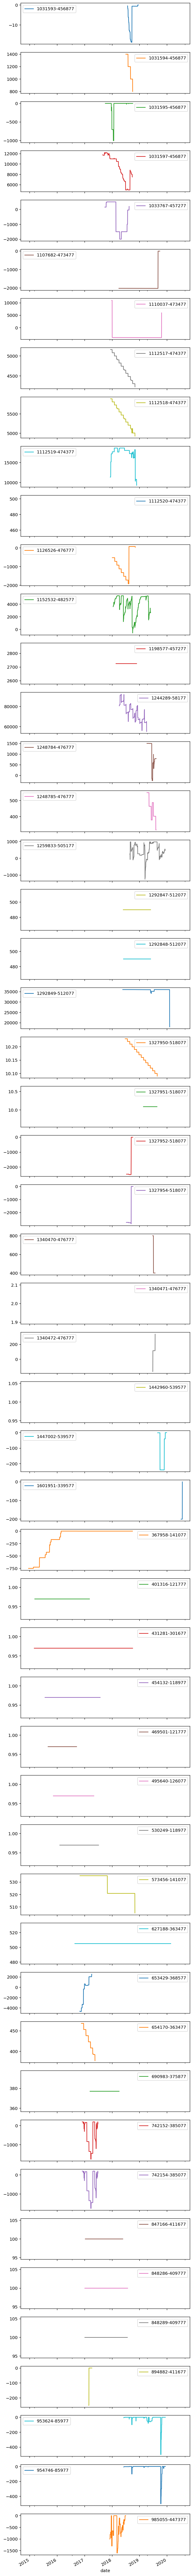

In [57]:
(daily_balances
 .pivot_table('balance', 'date', 'account_label')
 .iloc[:,:]
 .plot(subplots=True, figsize=(7, 120)));

### Observable issues

## All accounts

In [32]:
SAMPLE_SIZE = df.user_id.nunique()

user_sample = pd.Series(df.user_id.unique()).sample(random_state=2312, n=SAMPLE_SIZE)
sample = df[df.user_id.isin(user_sample)]

In [46]:
daily_balances = (sample.set_index('date')
                  .groupby(['account_id', 'account_type', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .sort_values('user_id')
                  .assign(account_label=lambda x: x.account_type.astype('str') + '-' + x.account_id.astype('str')))

daily_balances.head(3)

account_id account_type  user_id       date  balance  \
48079      446213  credit card    17277 2015-04-10     0.01   
19262      230283      current    17277 2014-09-07     0.42   
19263      230283      current    17277 2014-09-08     0.42   

            account_label  
48079  credit card-446213  
19262      current-230283  
19263      current-230283

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


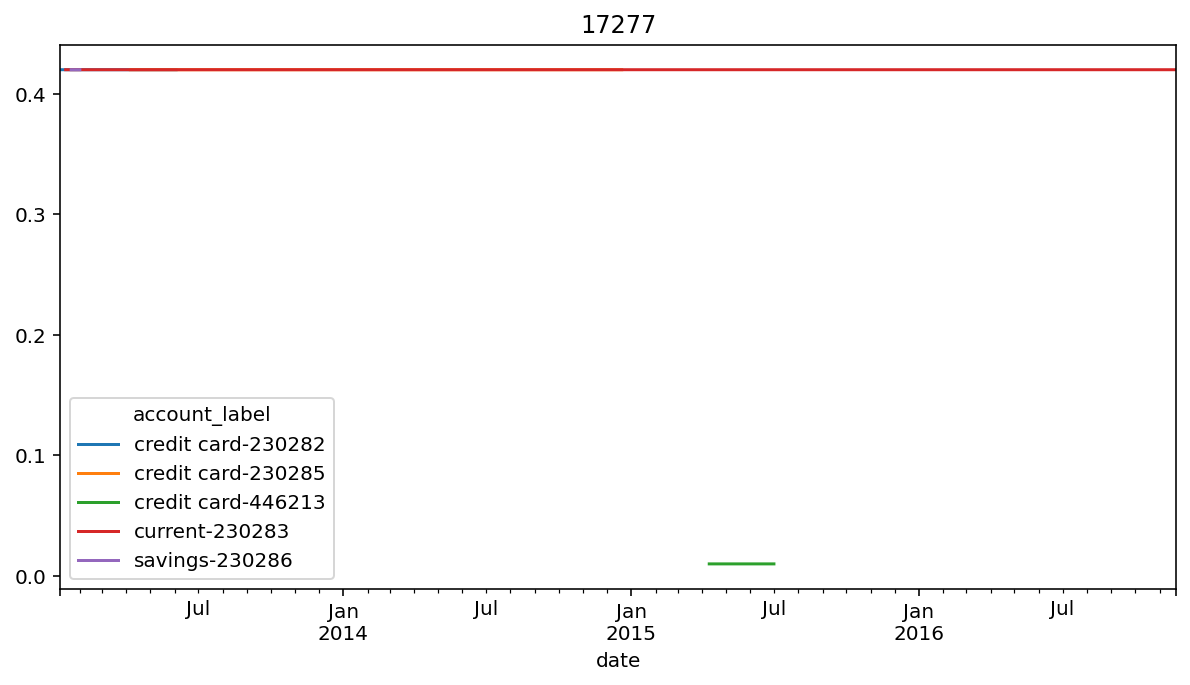

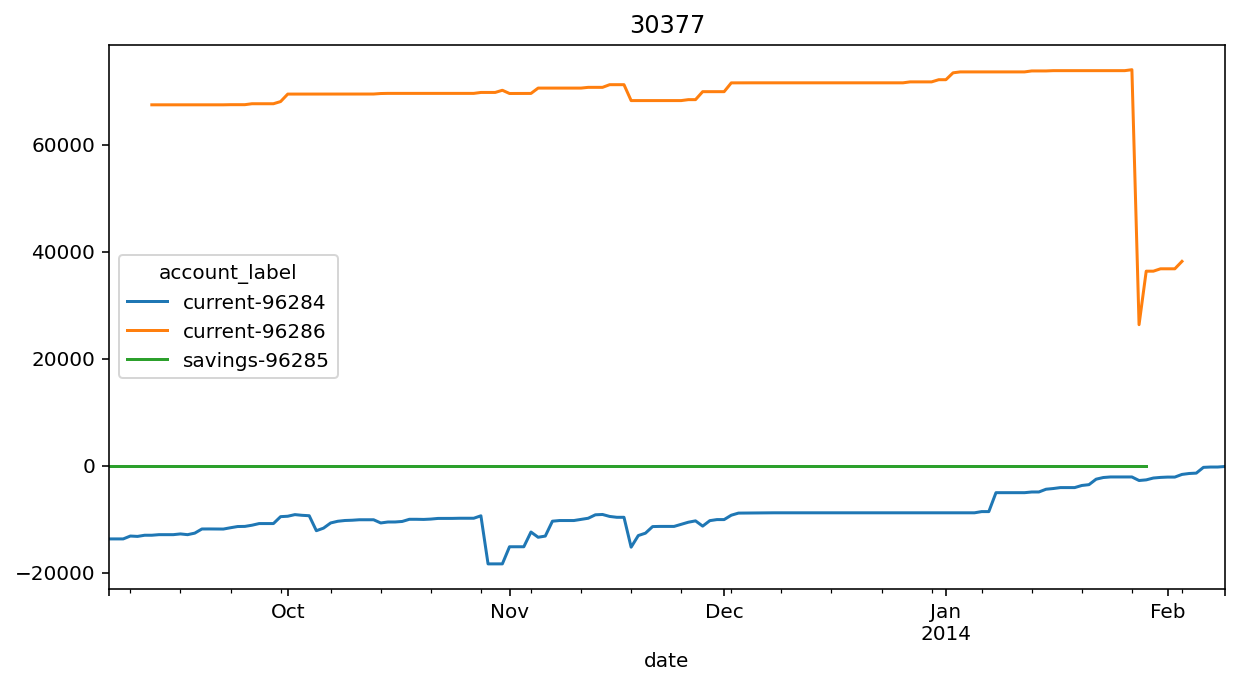

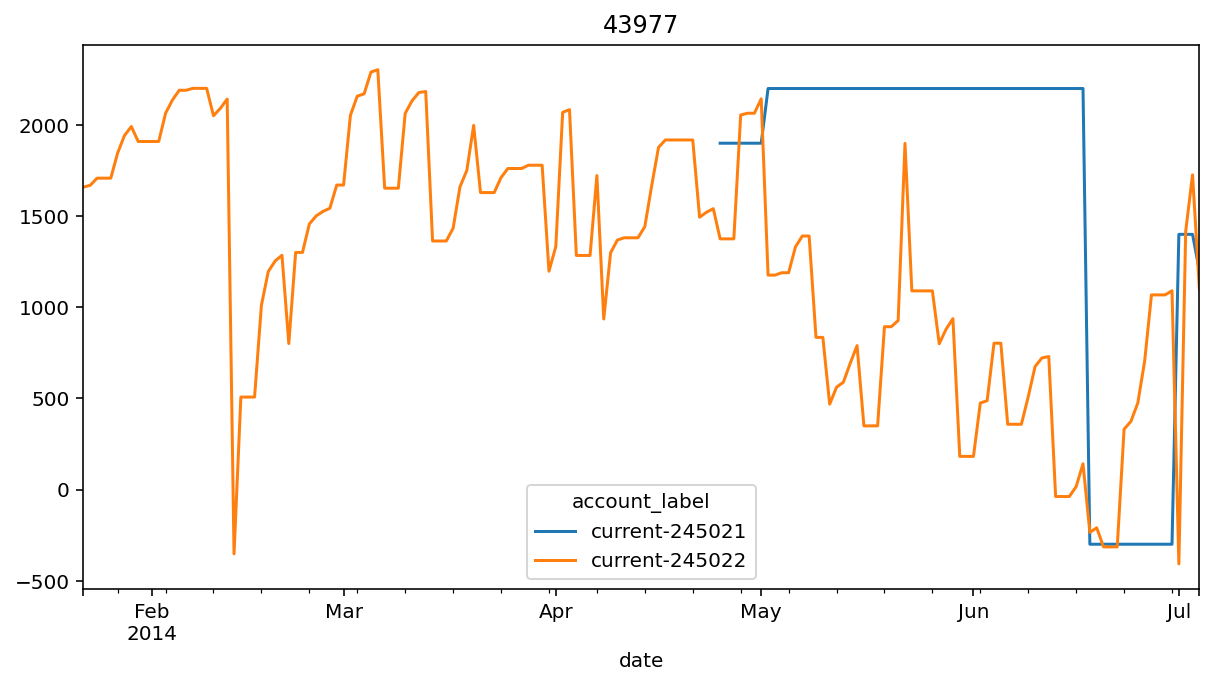

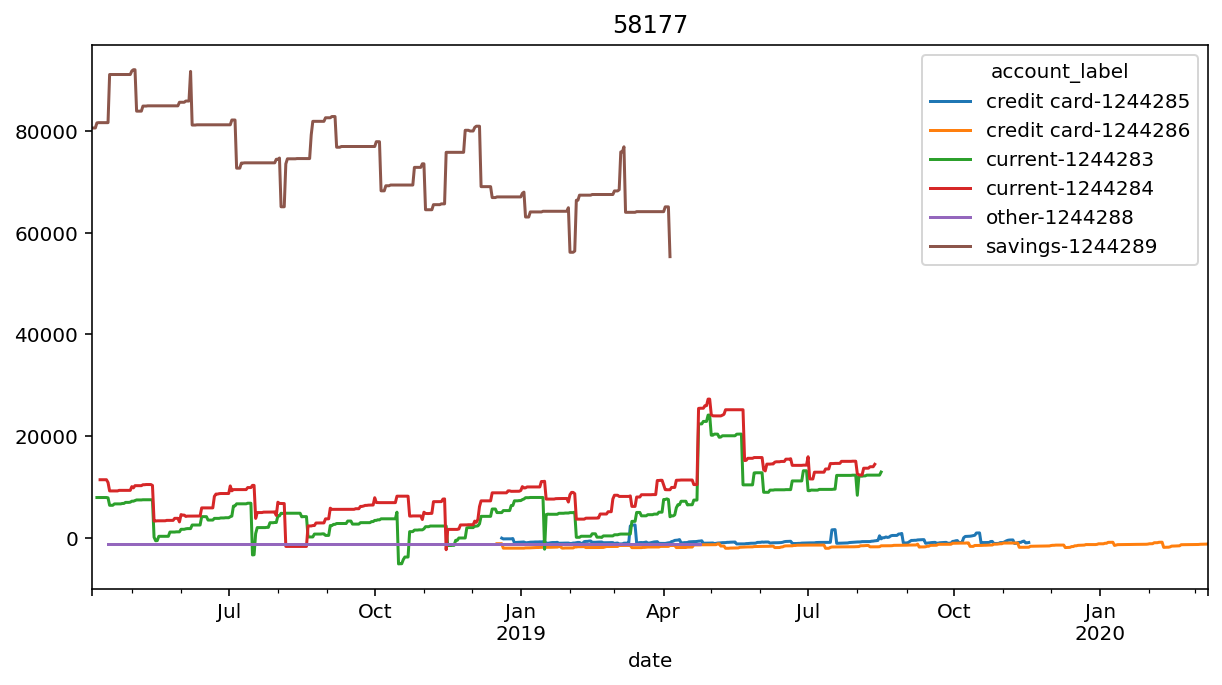

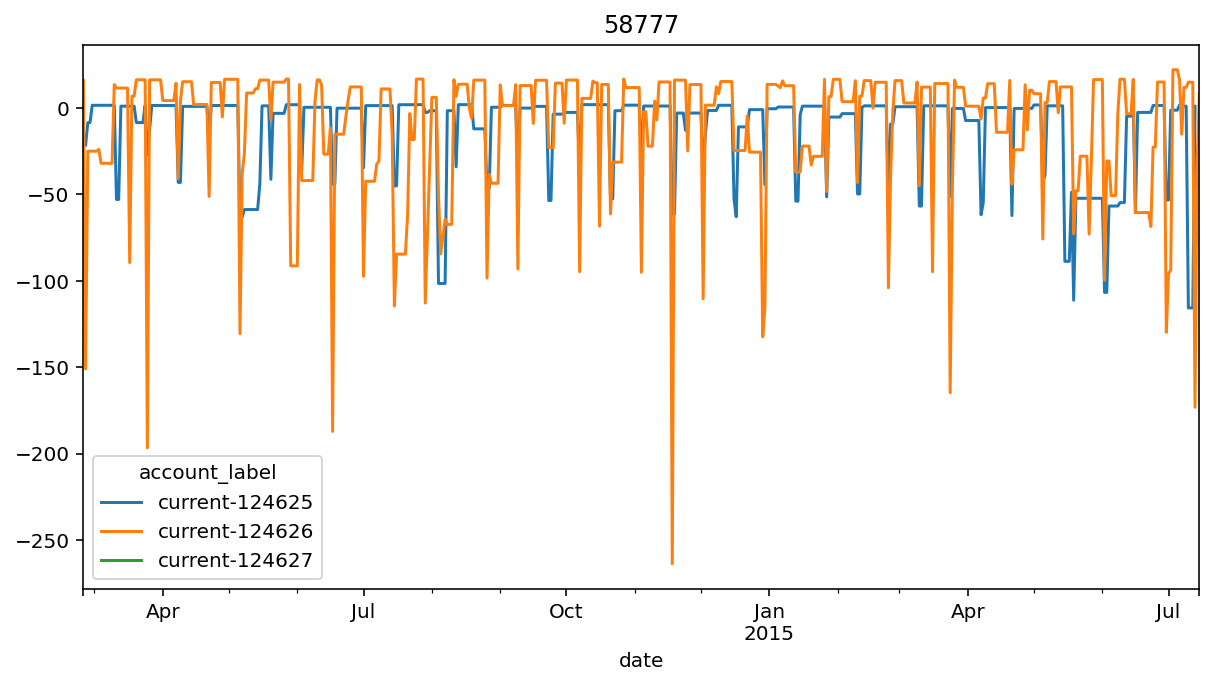

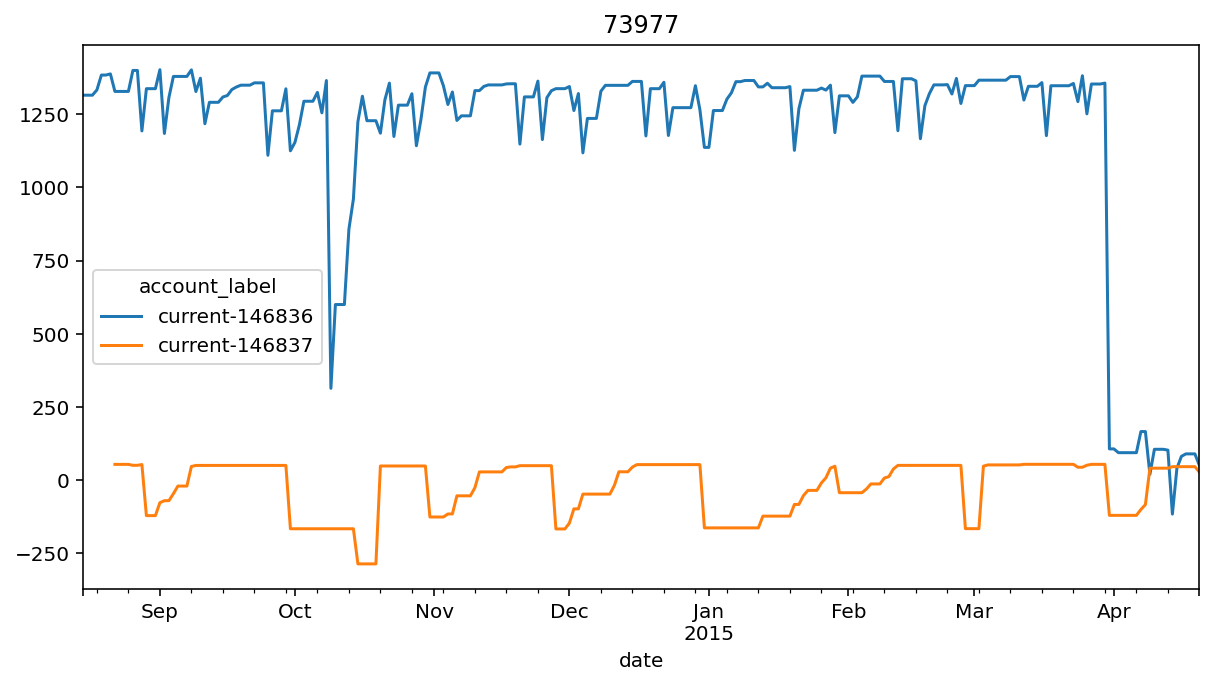

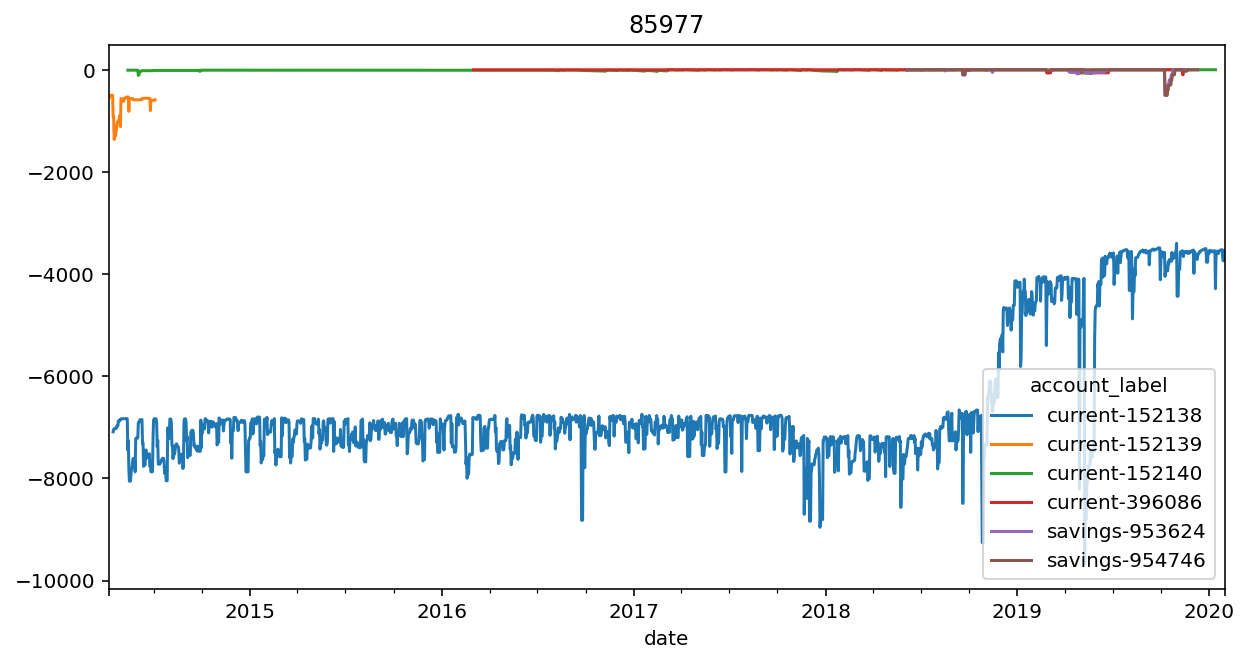

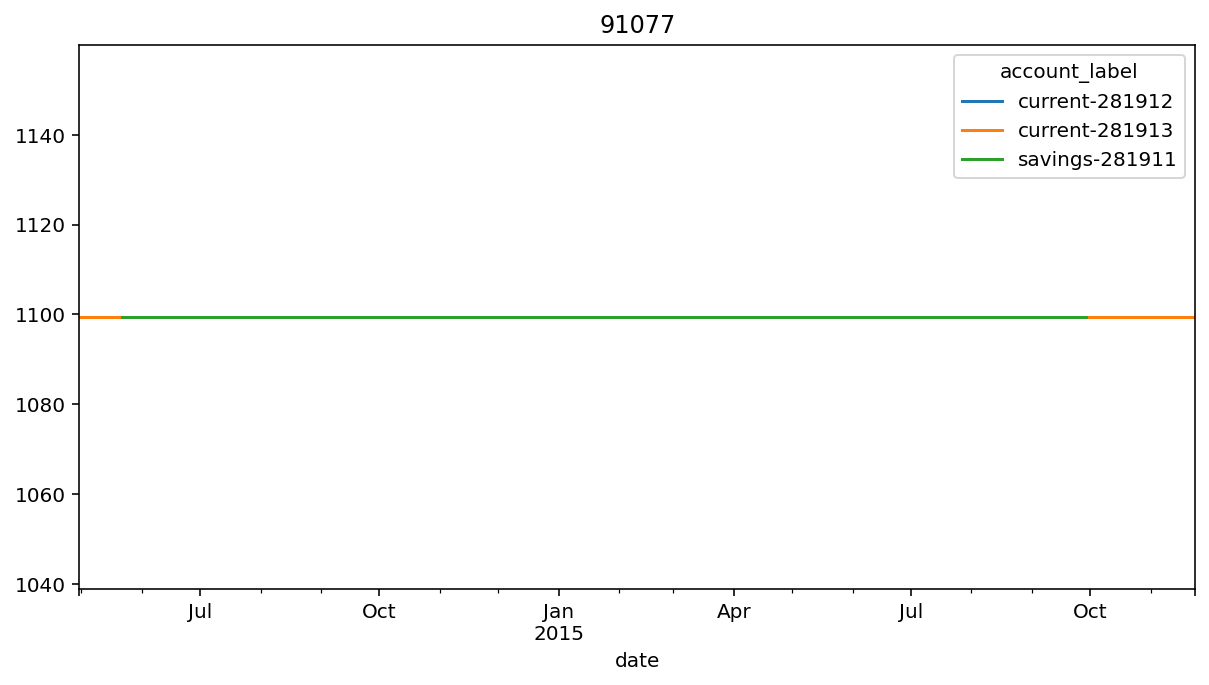

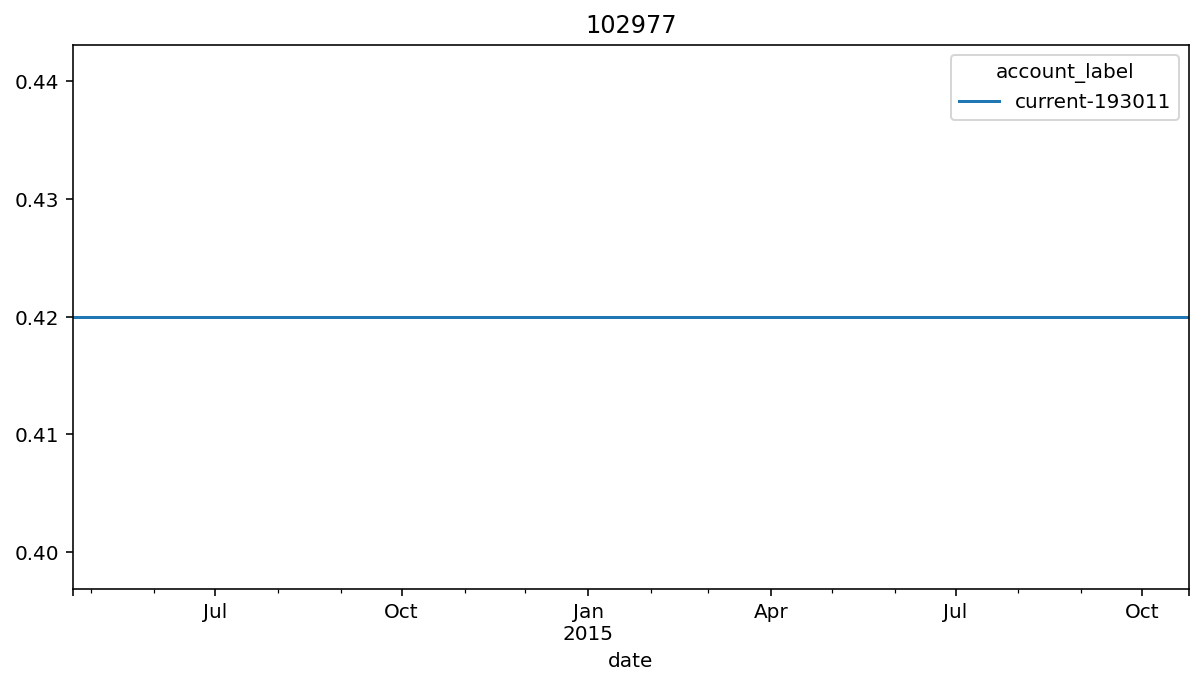

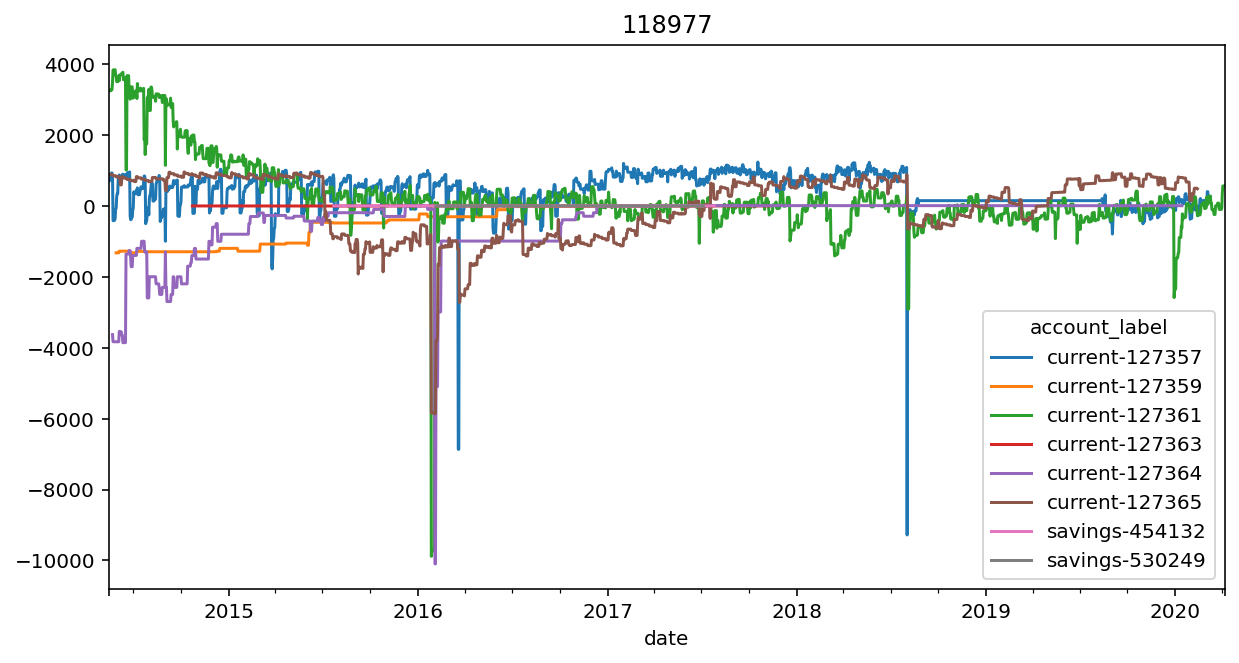

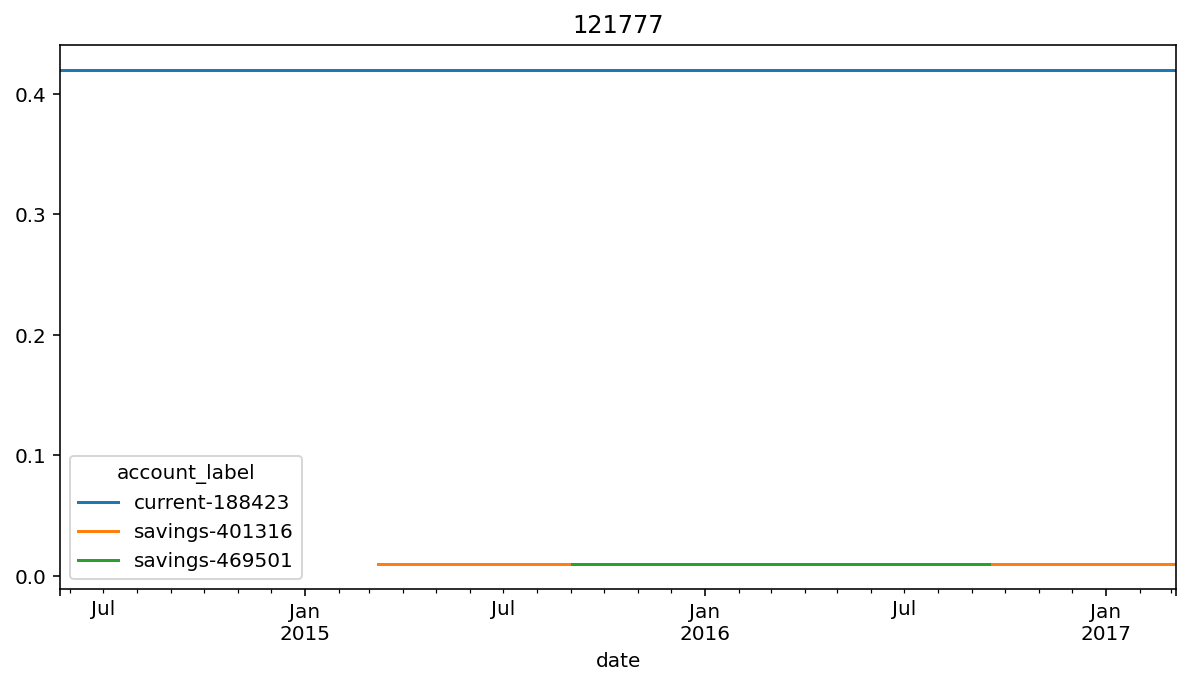

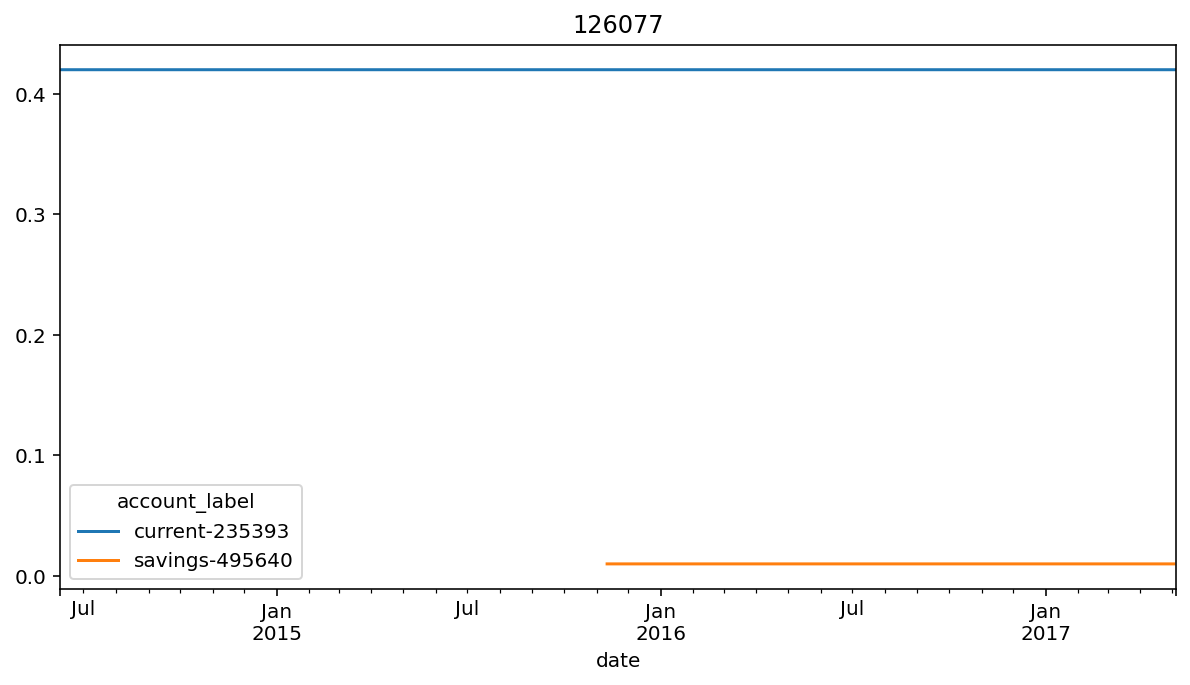

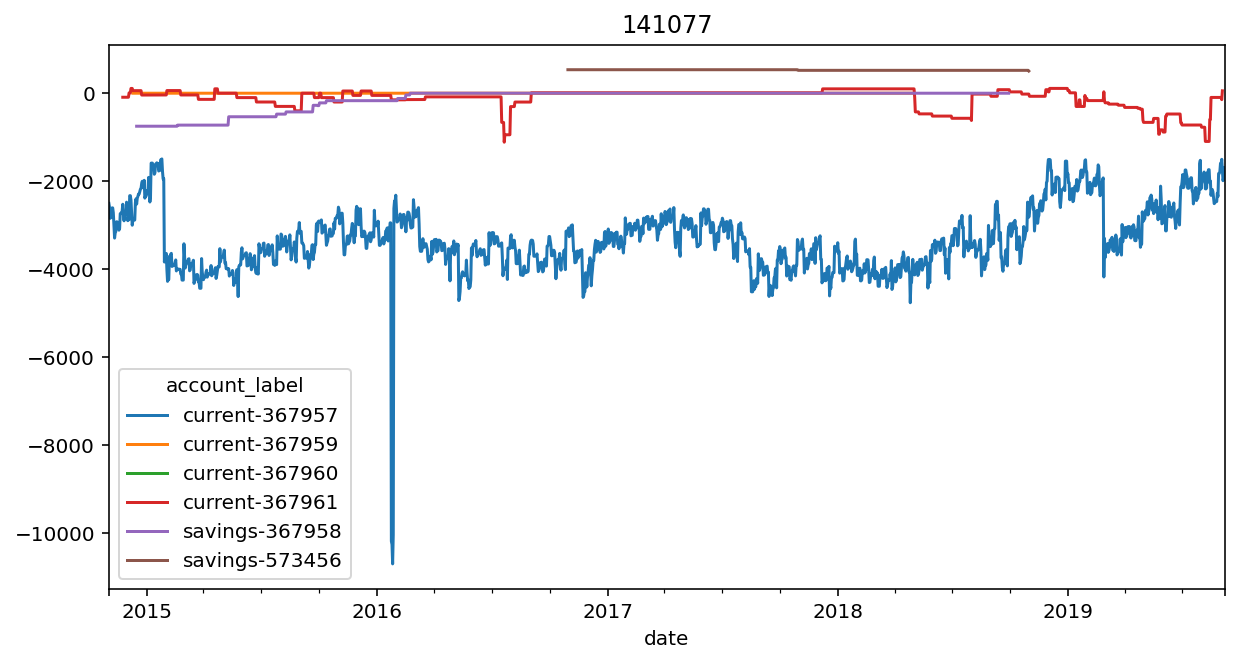

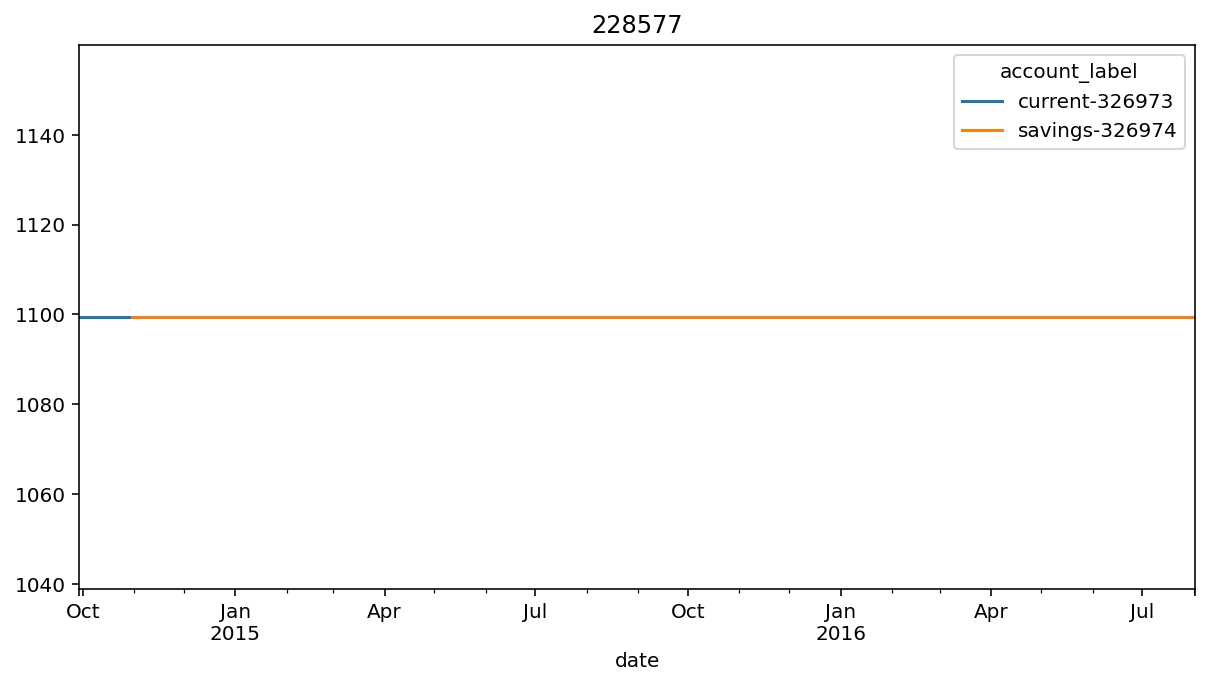

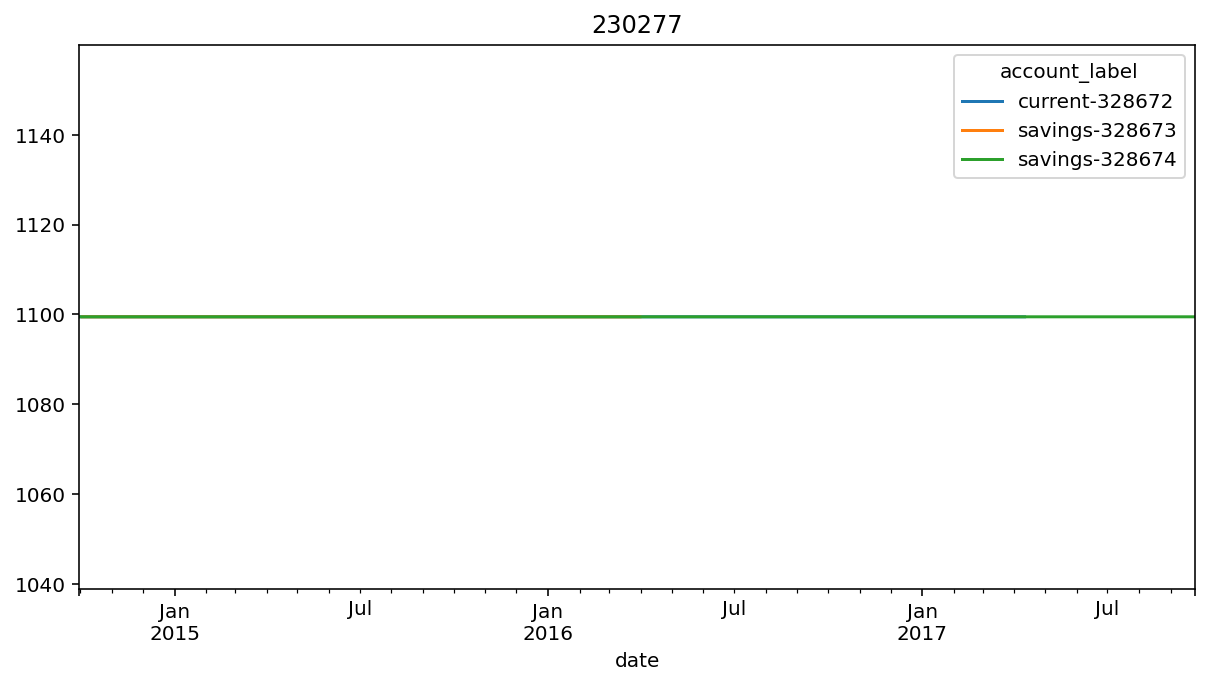

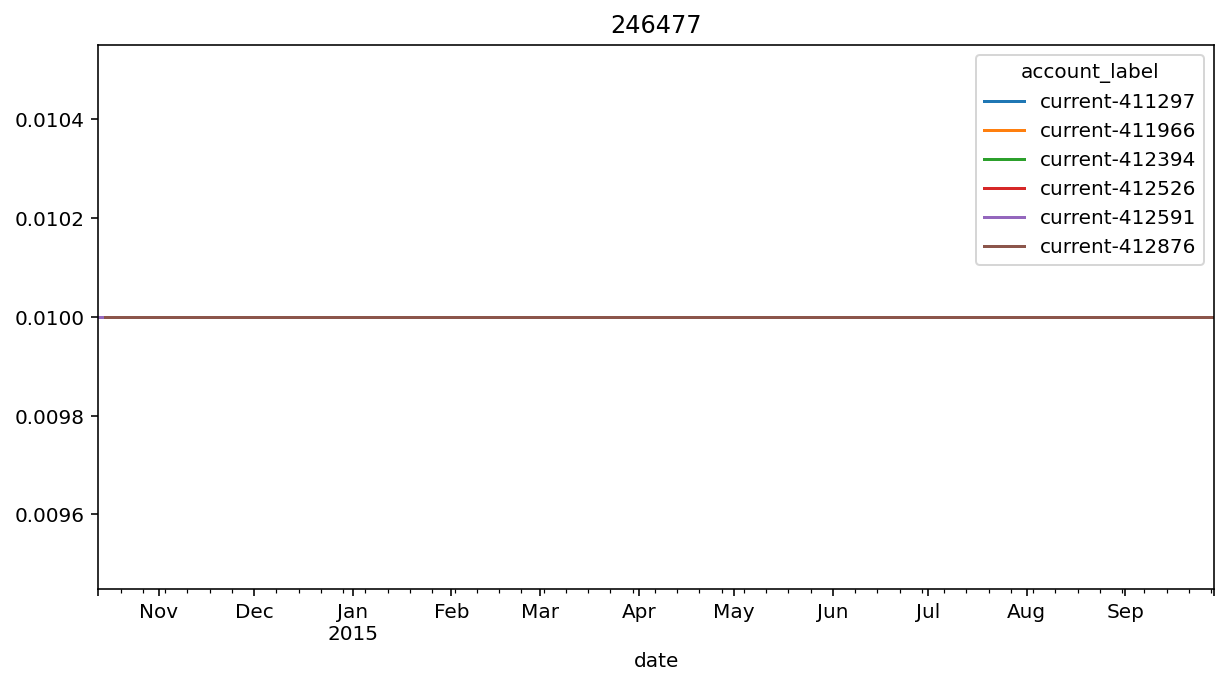

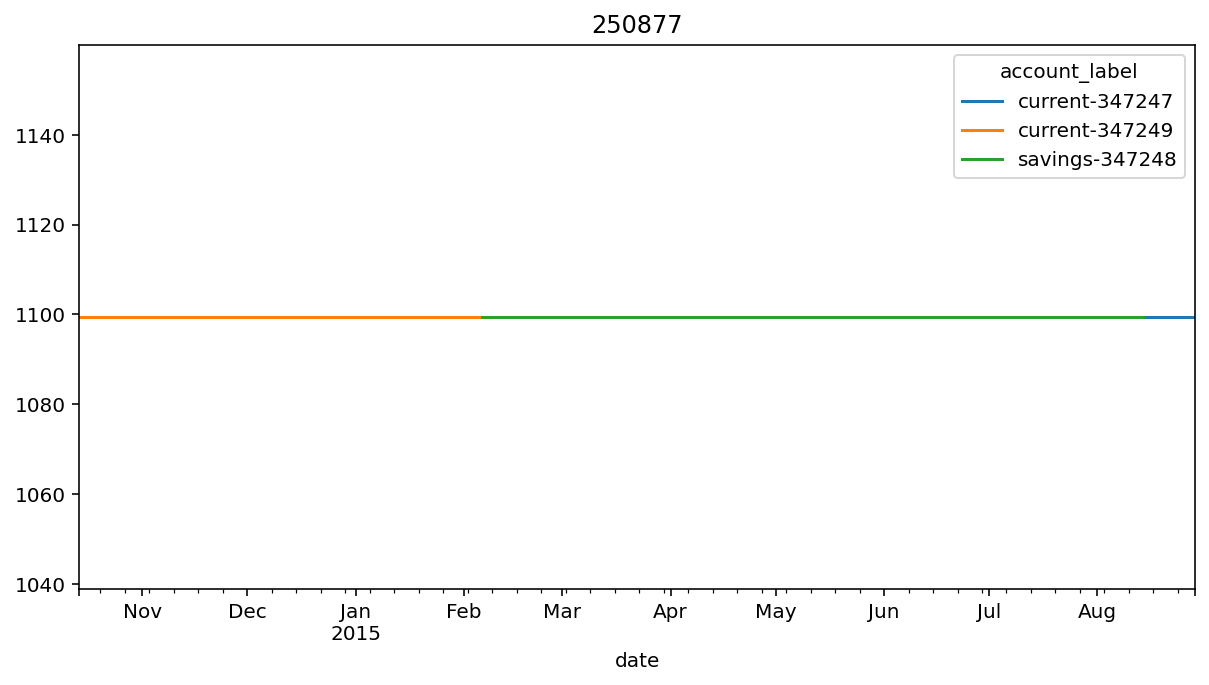

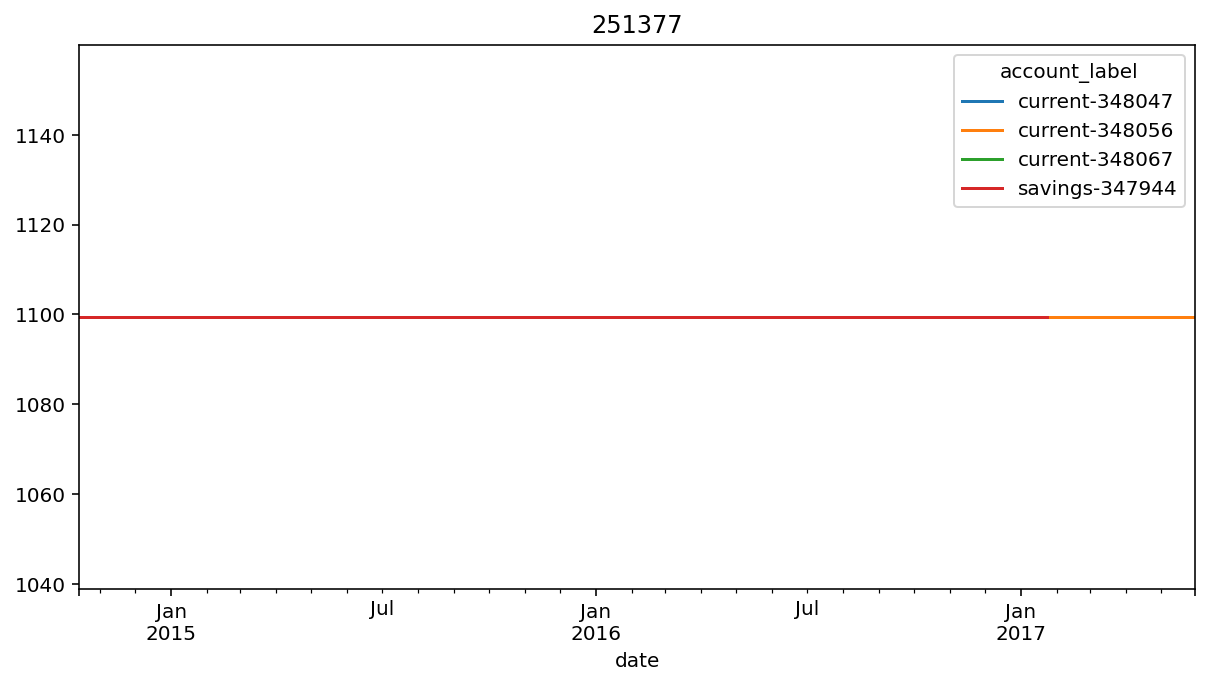

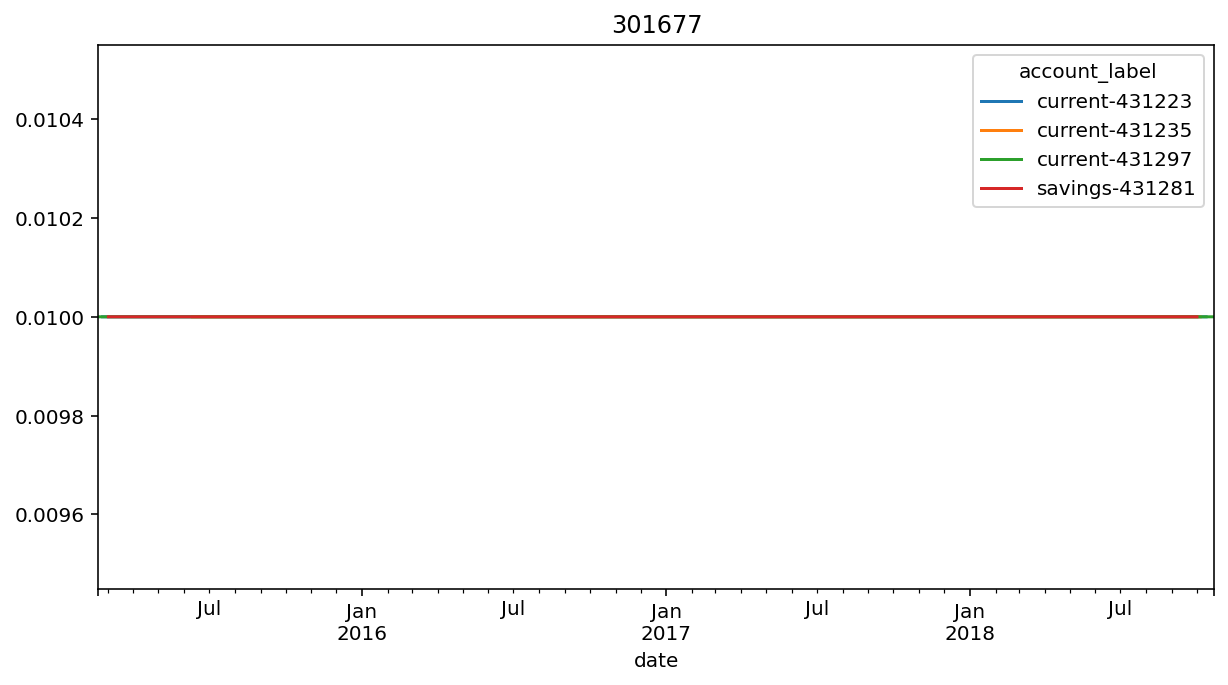

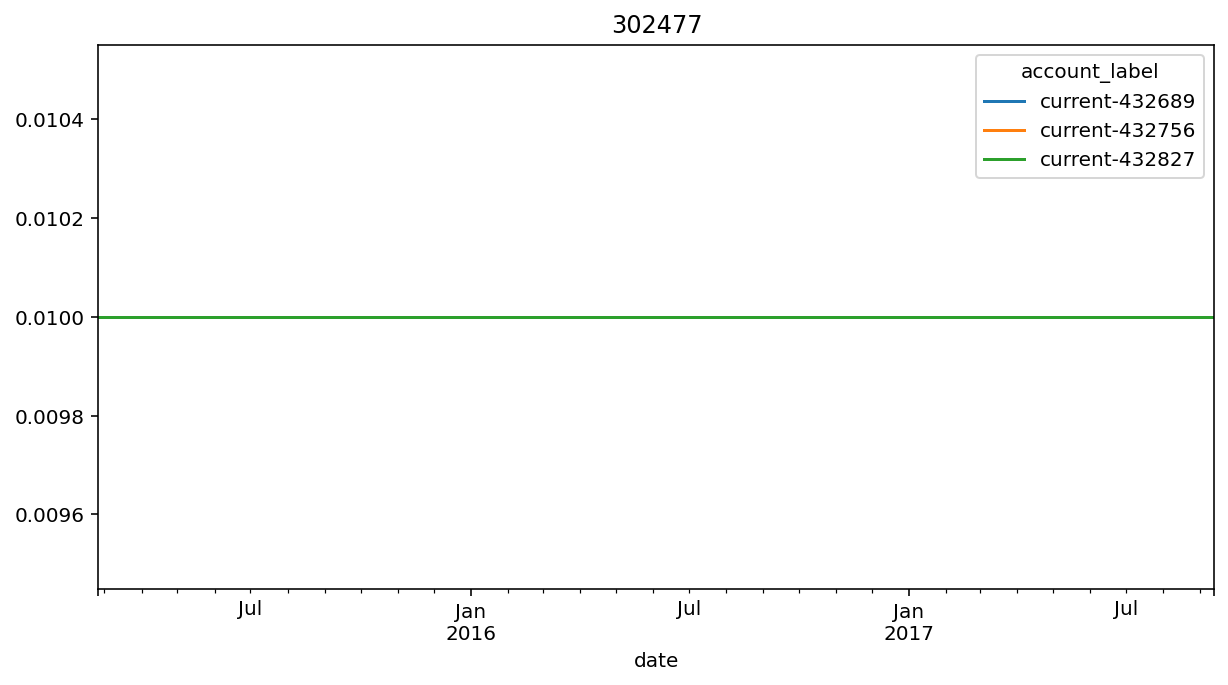

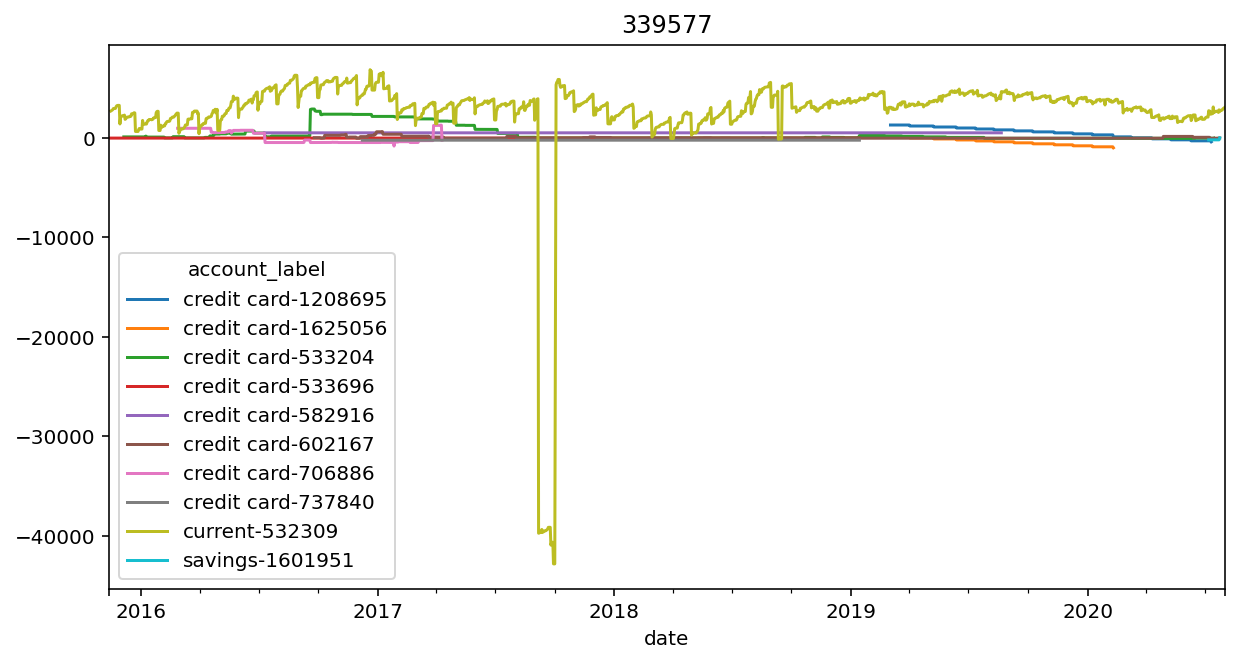

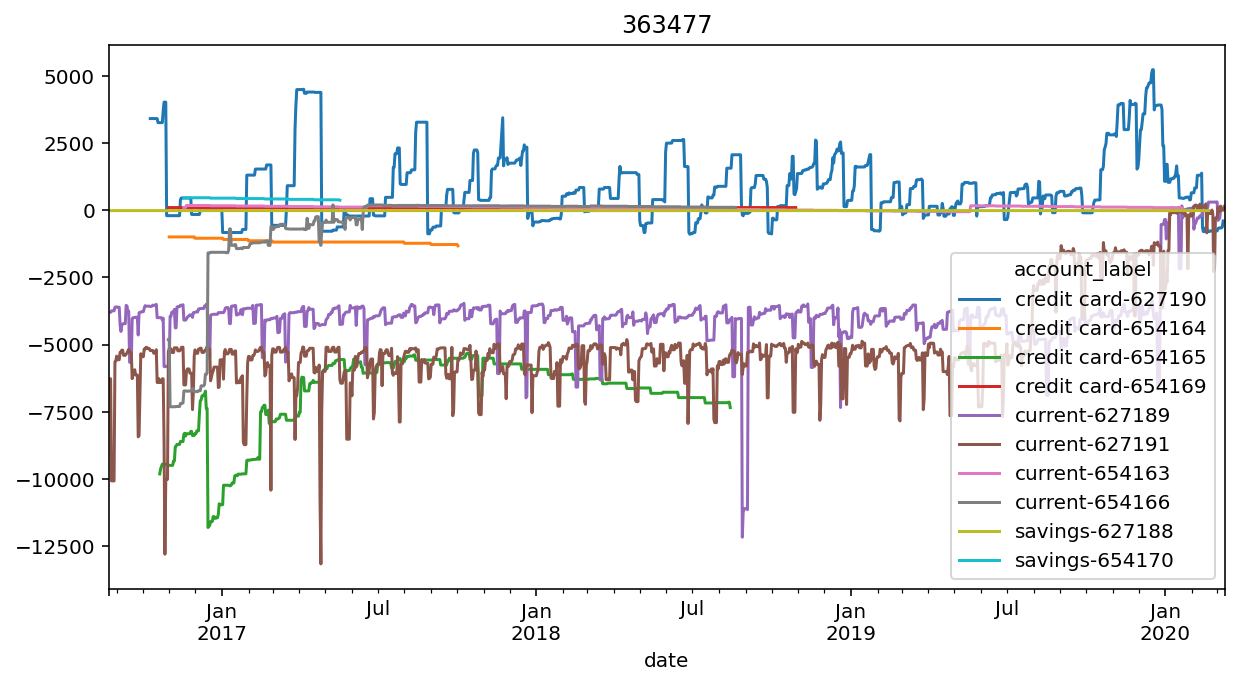

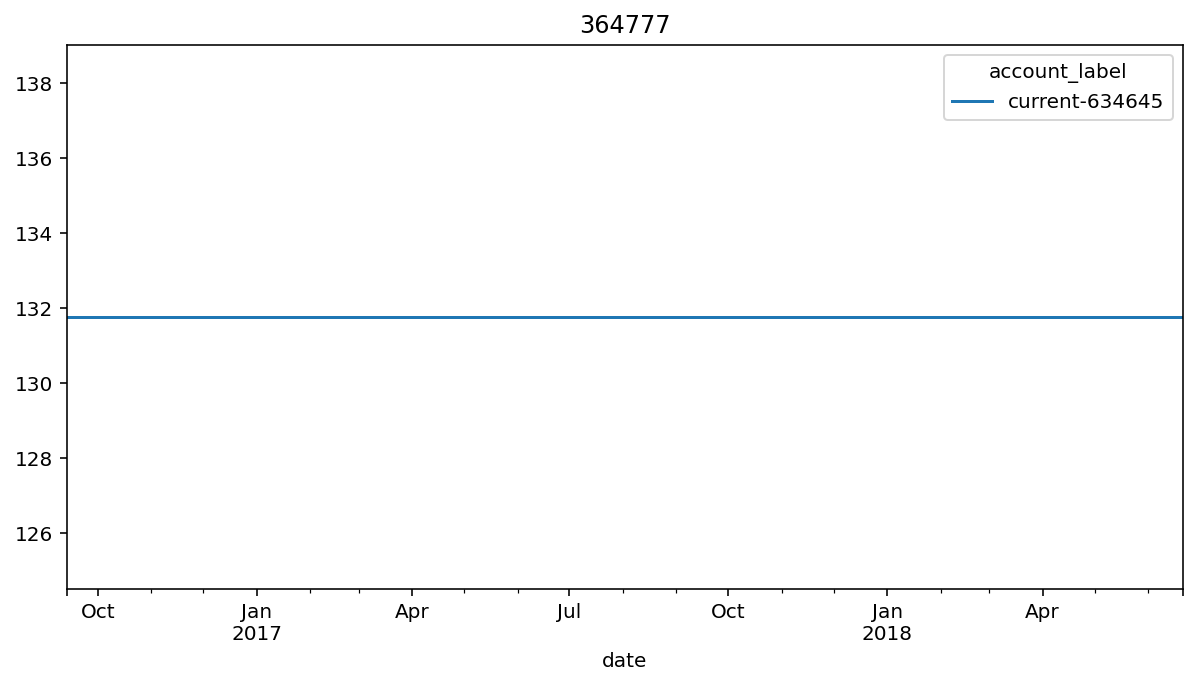

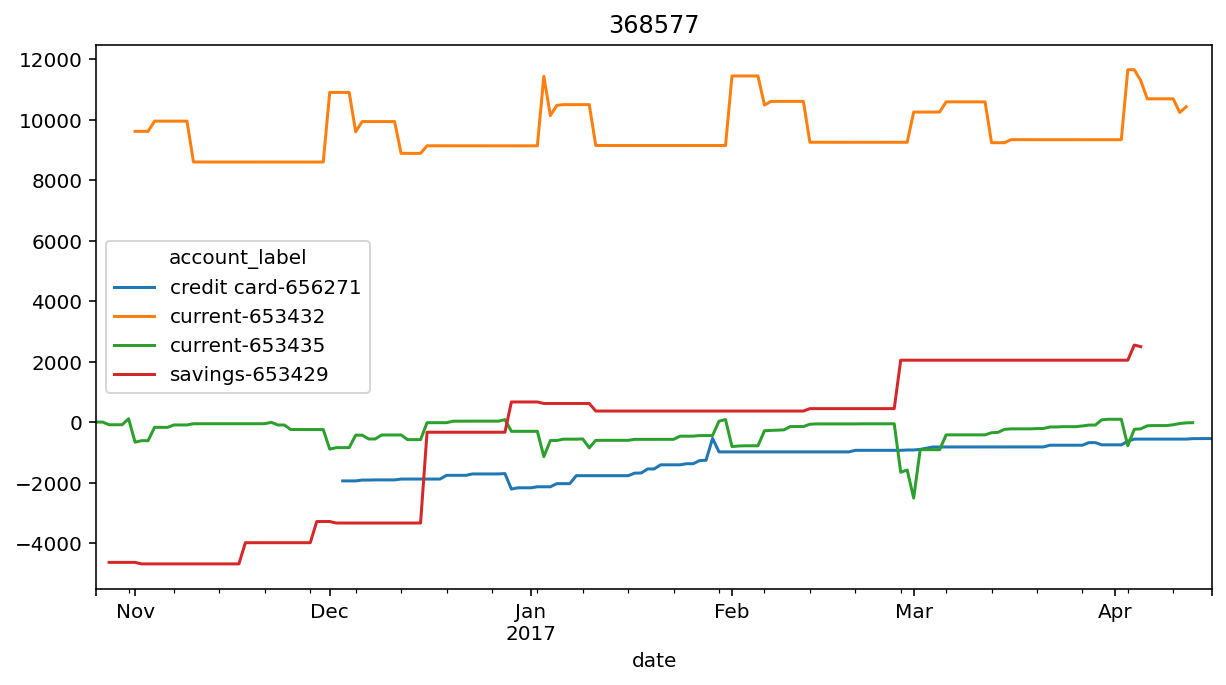

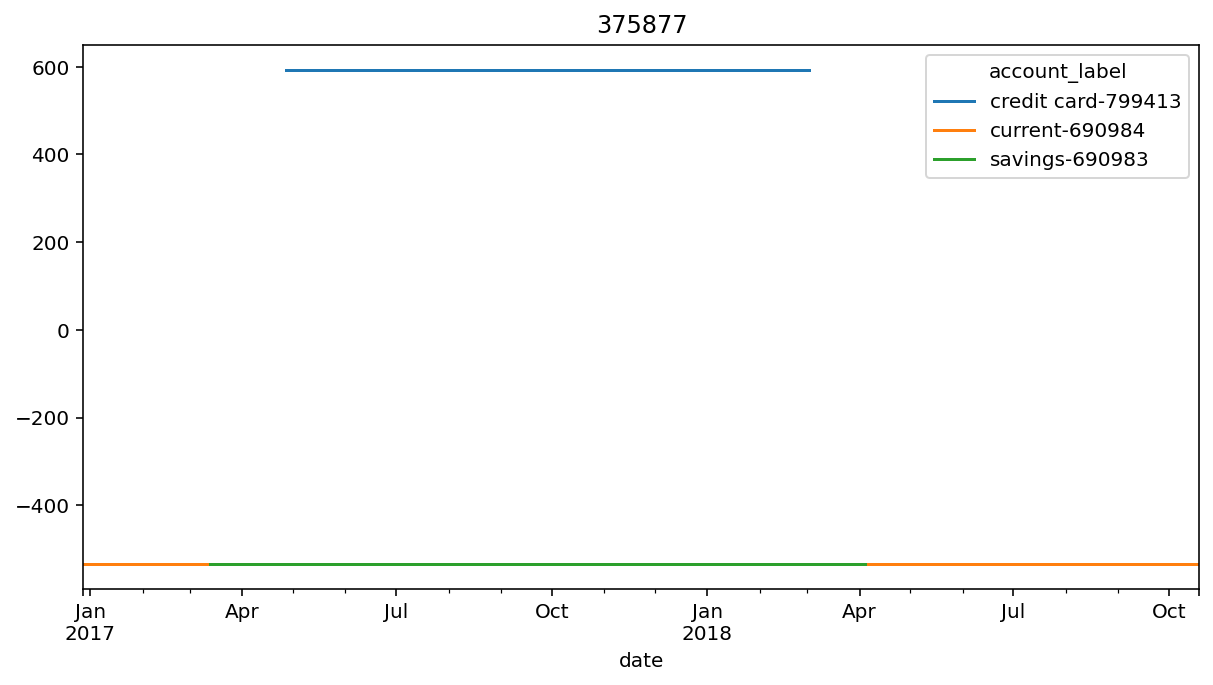

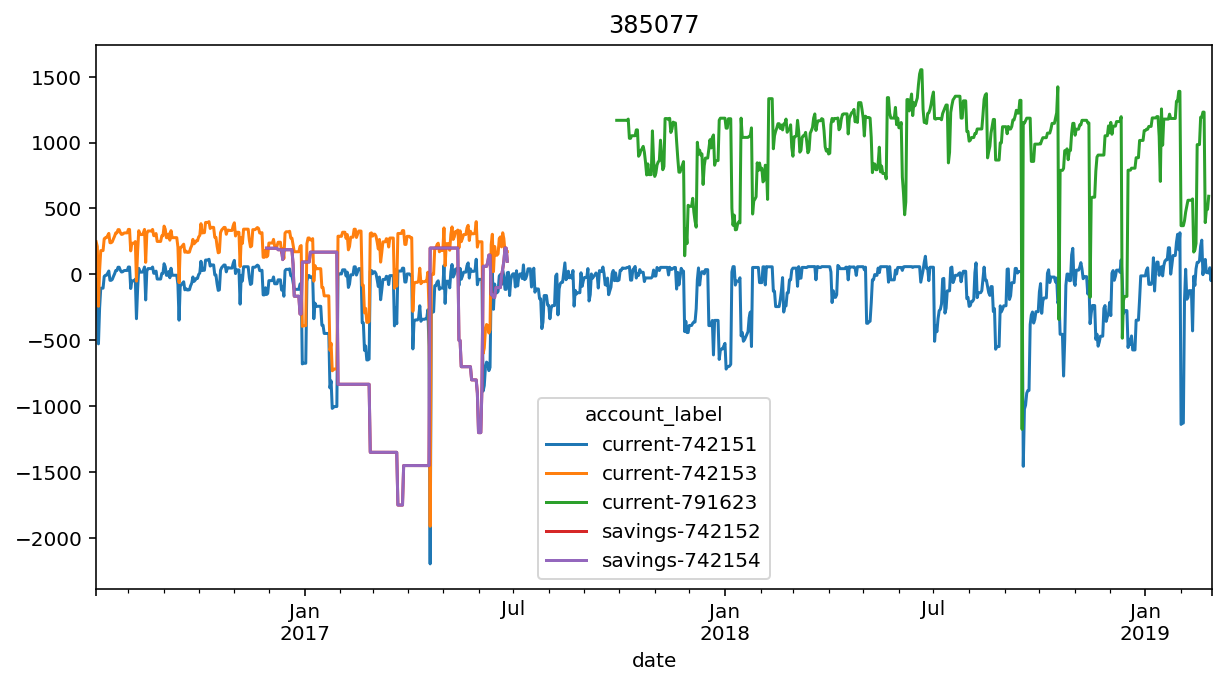

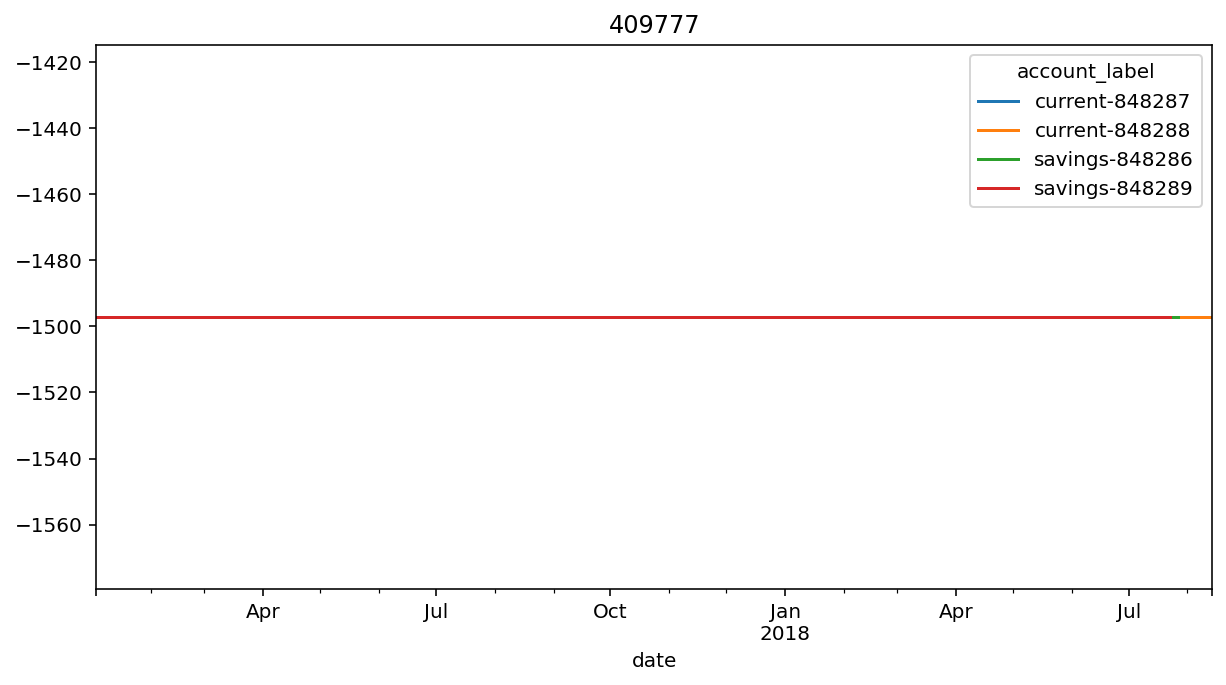

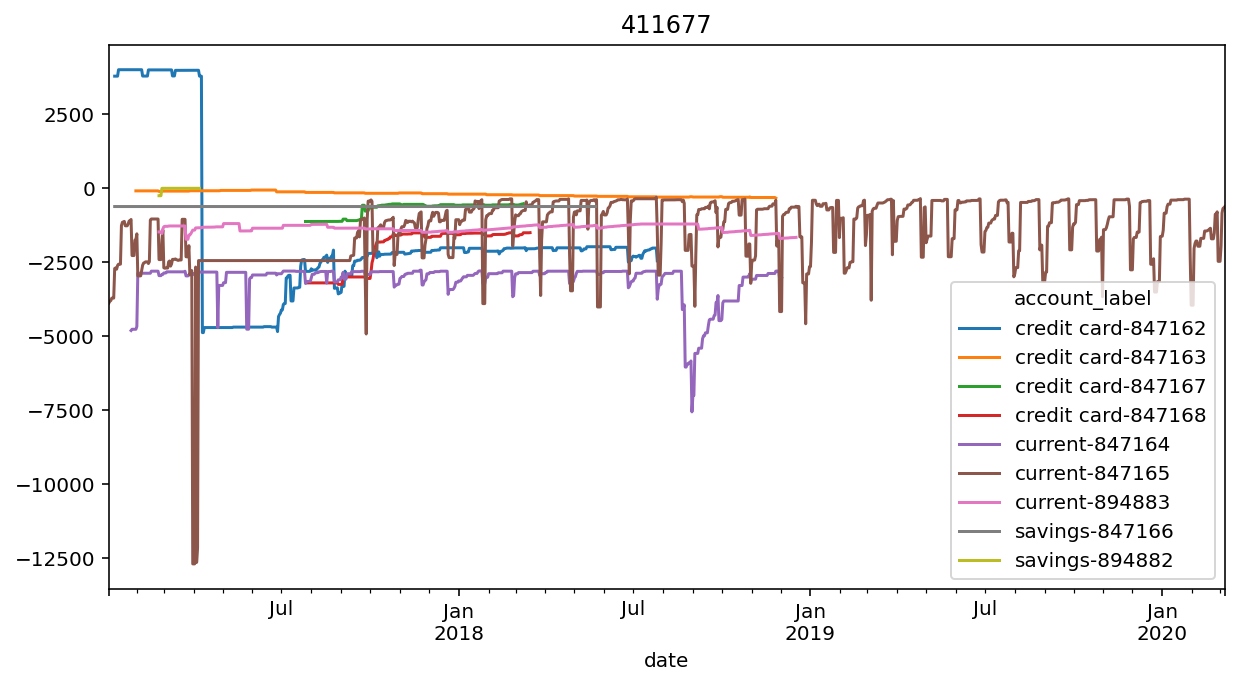

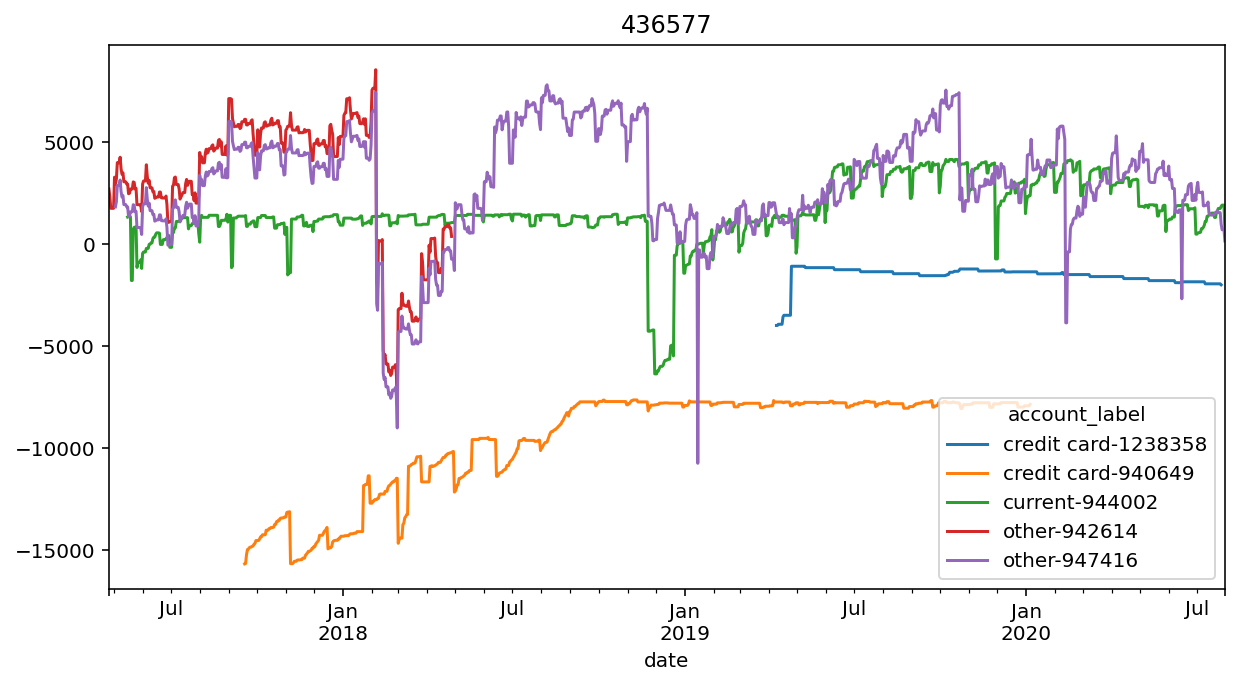

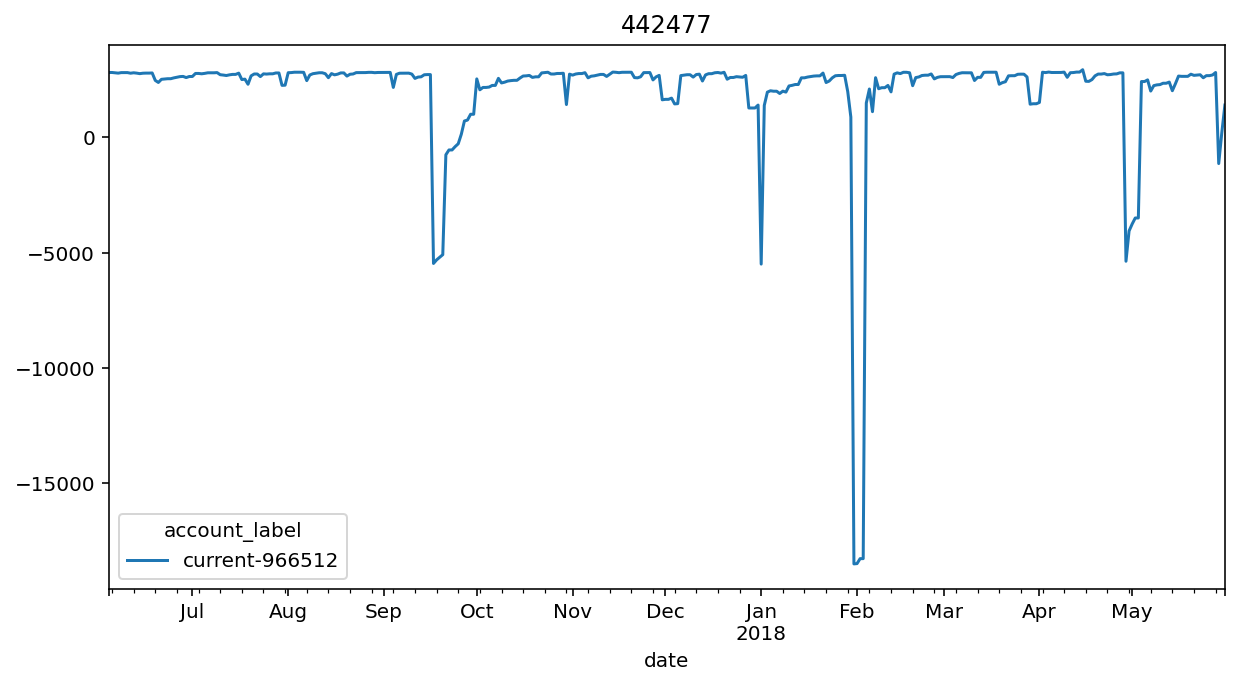

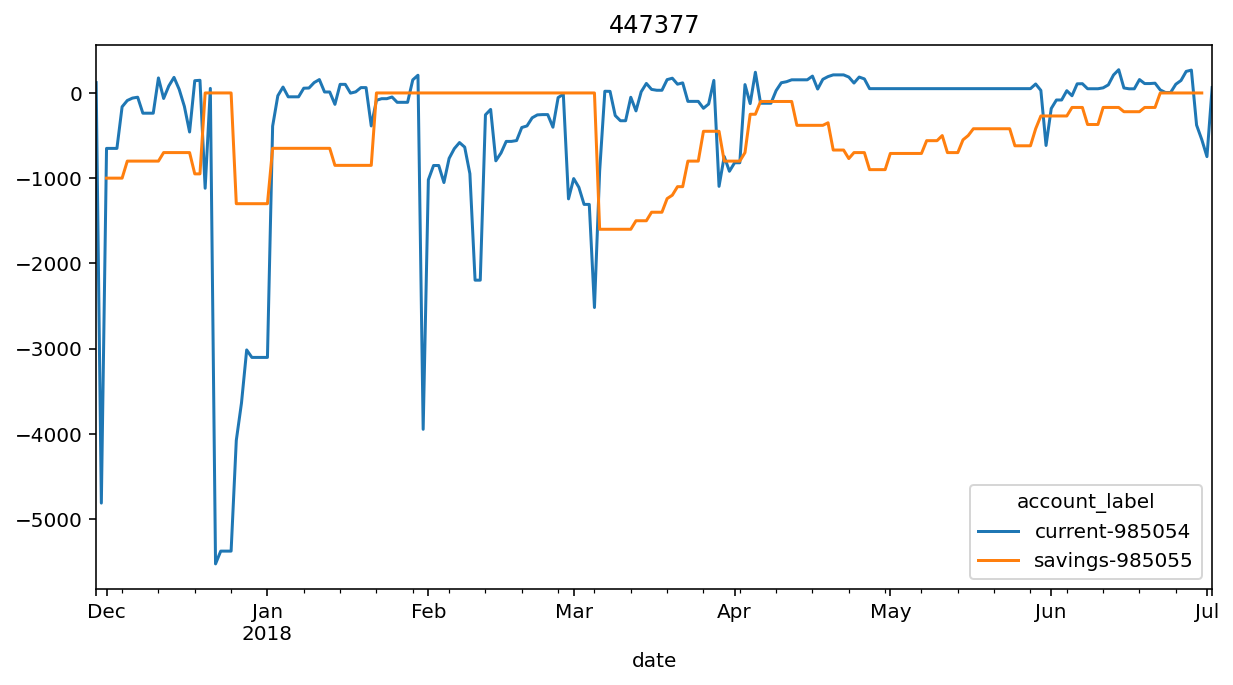

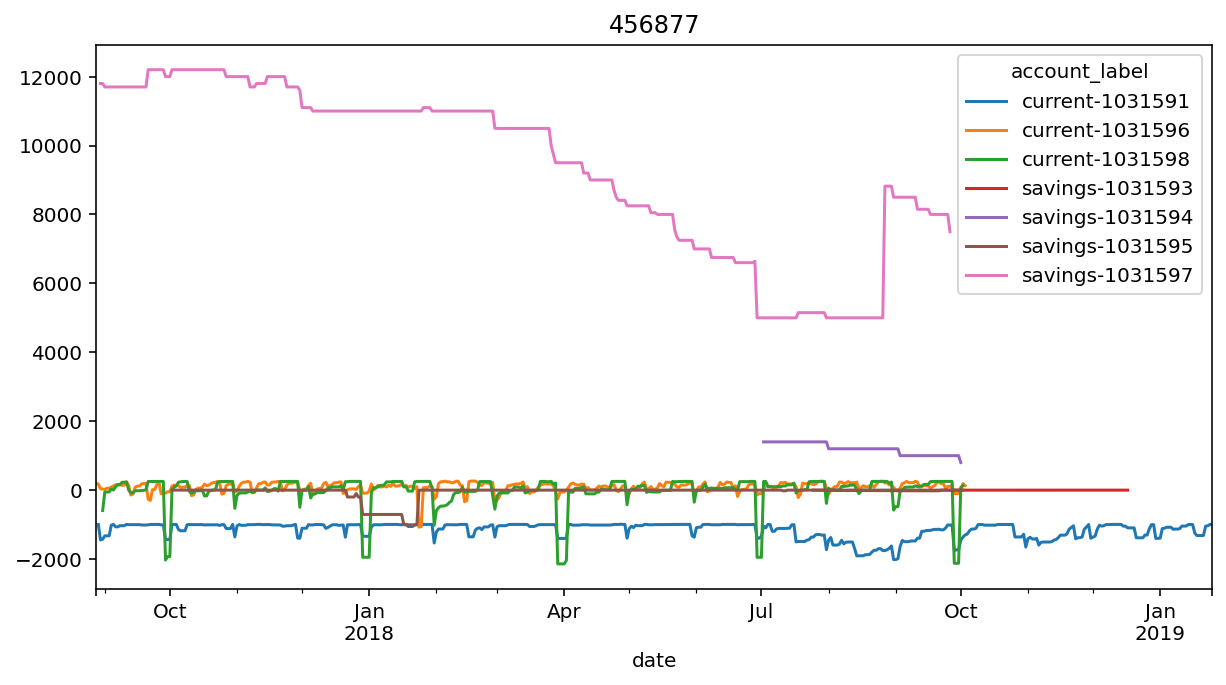

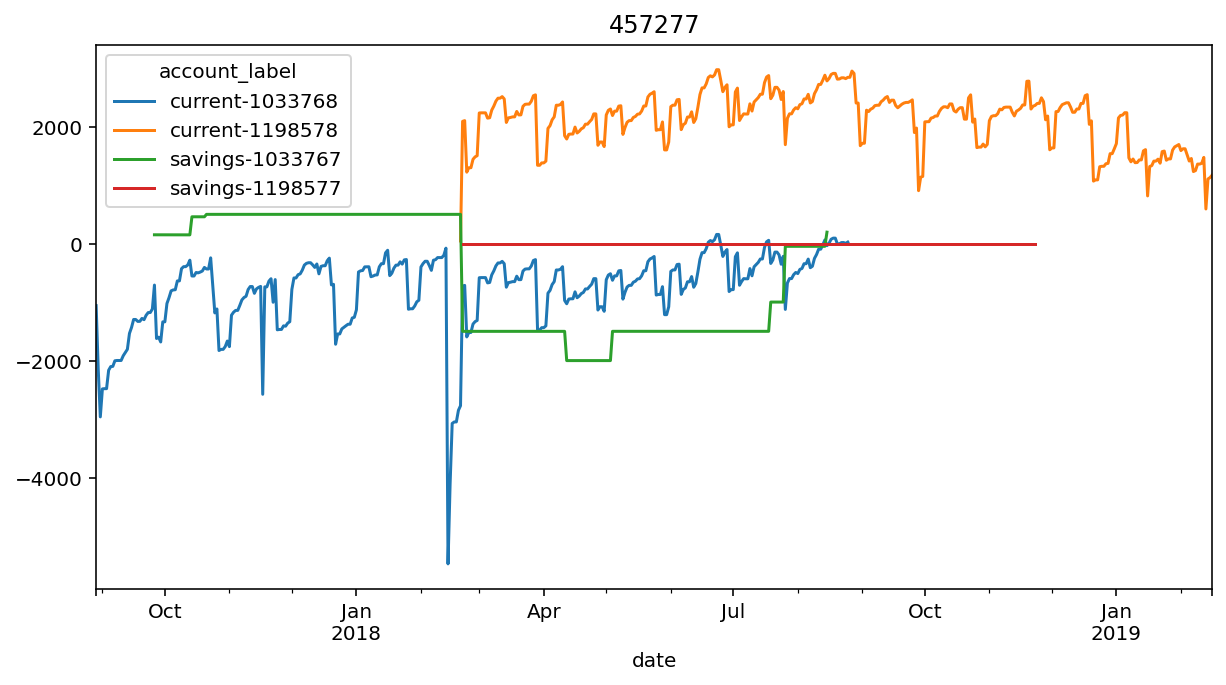

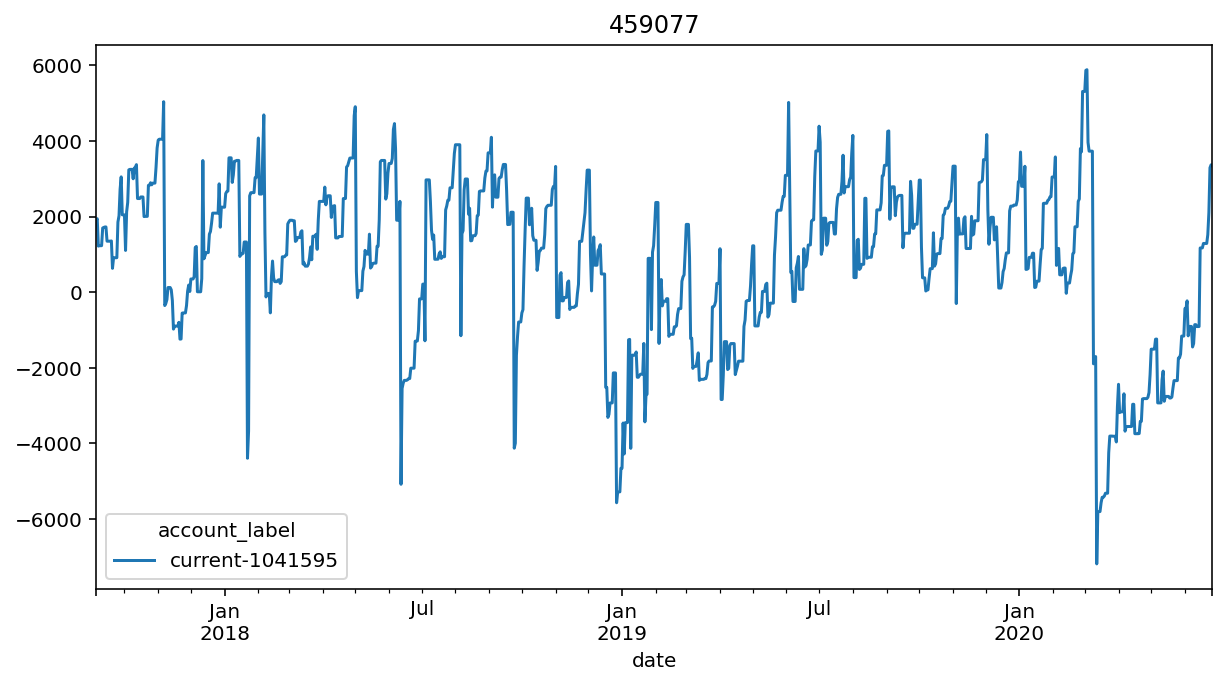

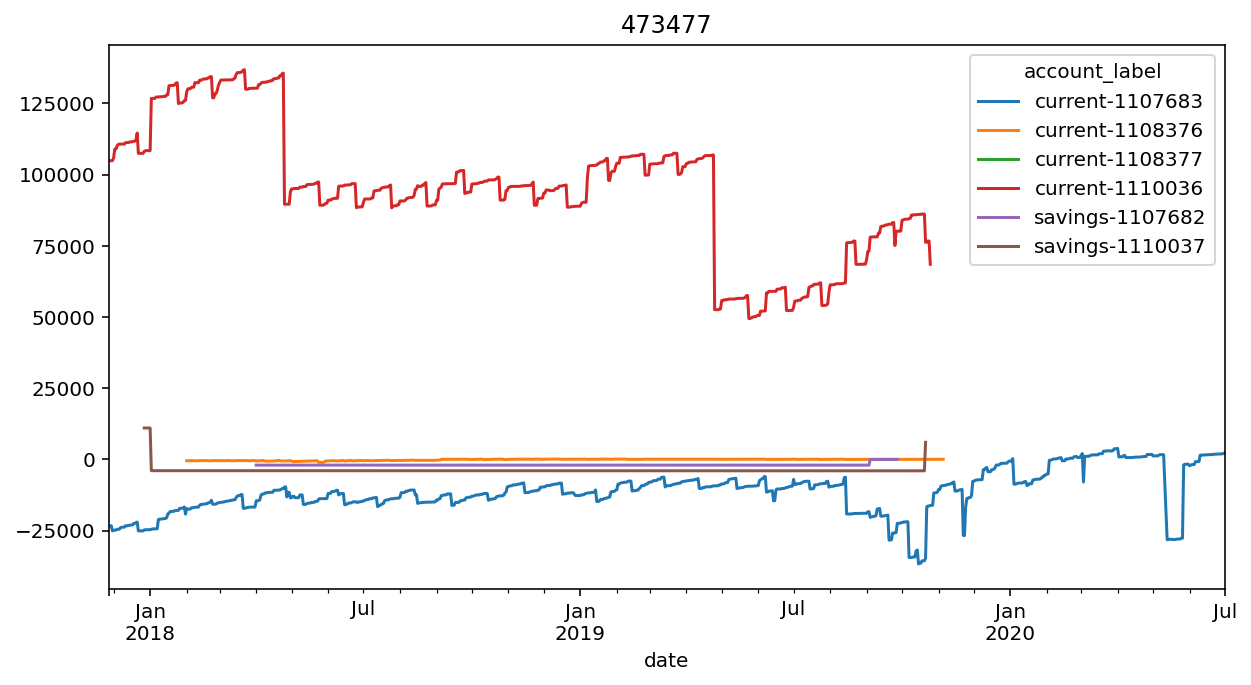

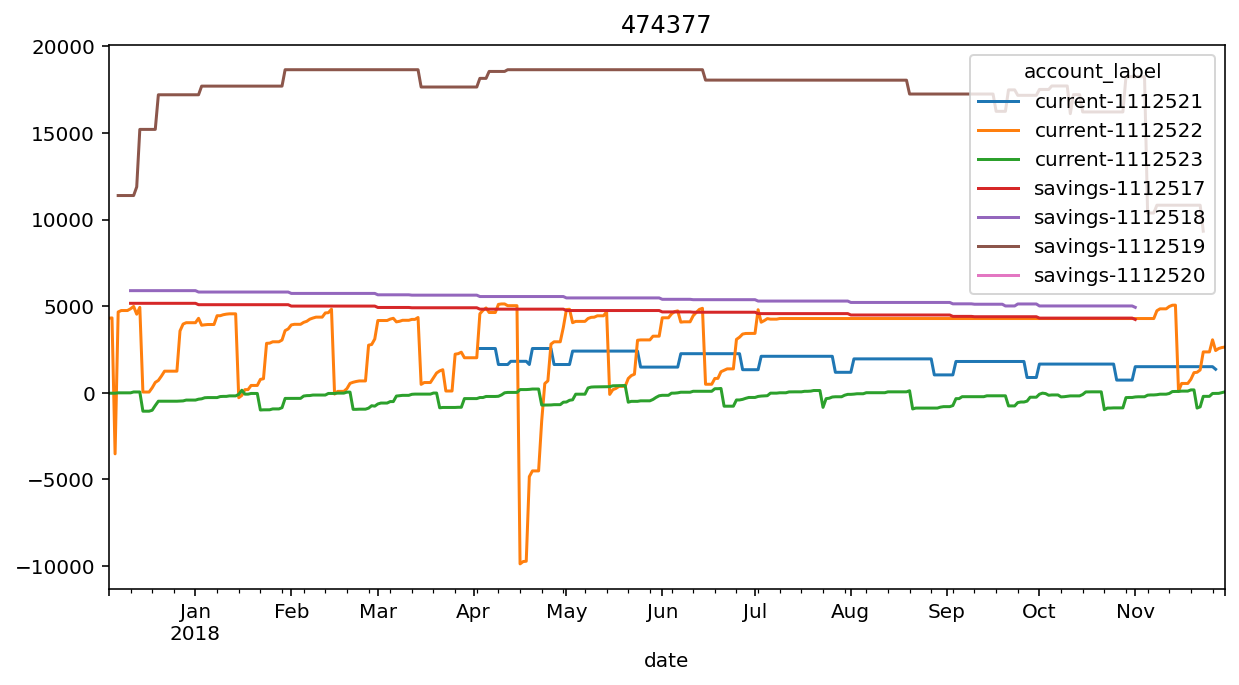

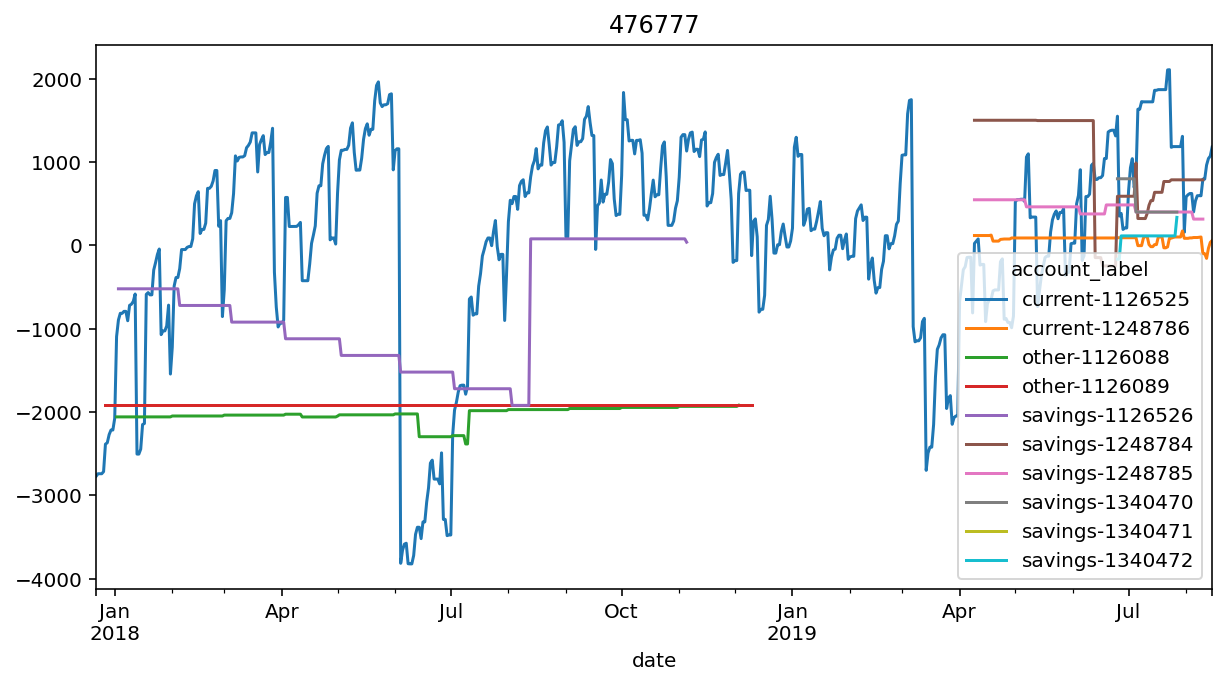

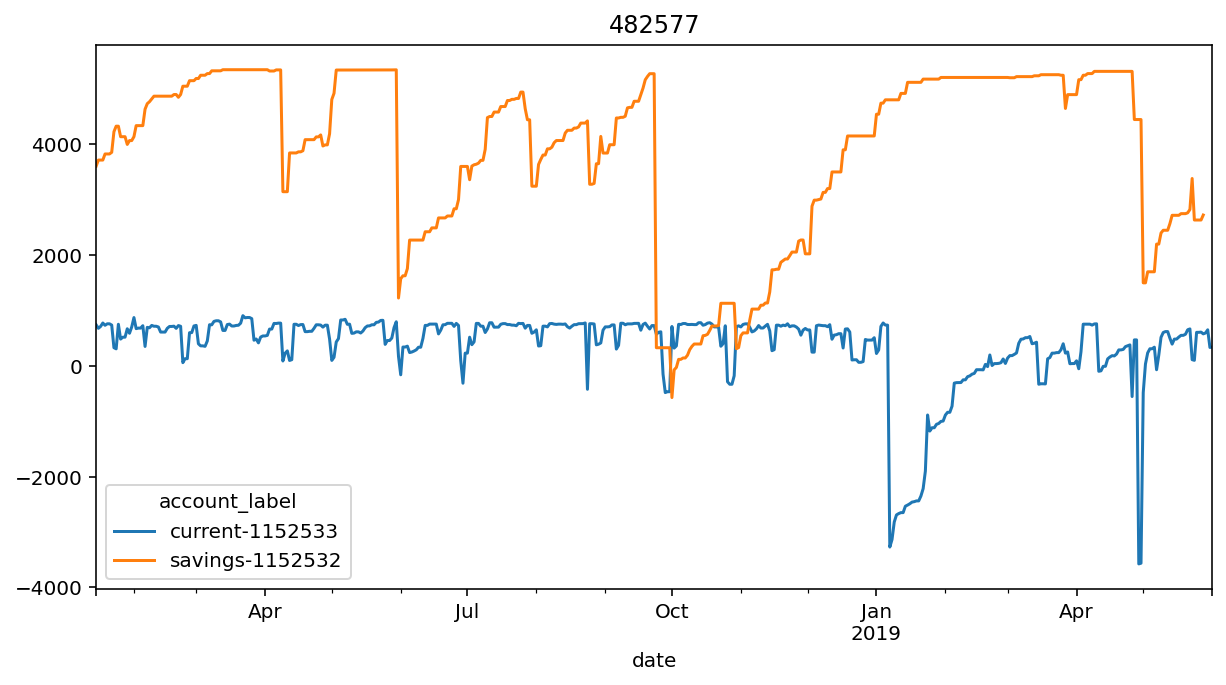

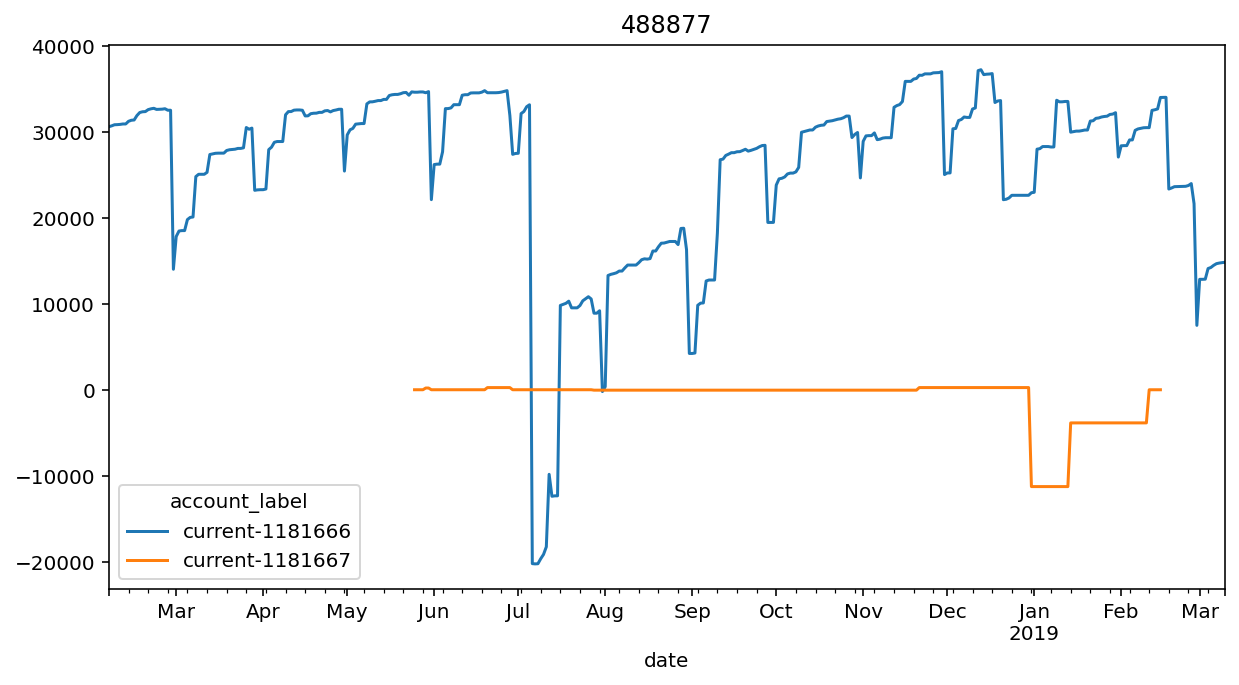

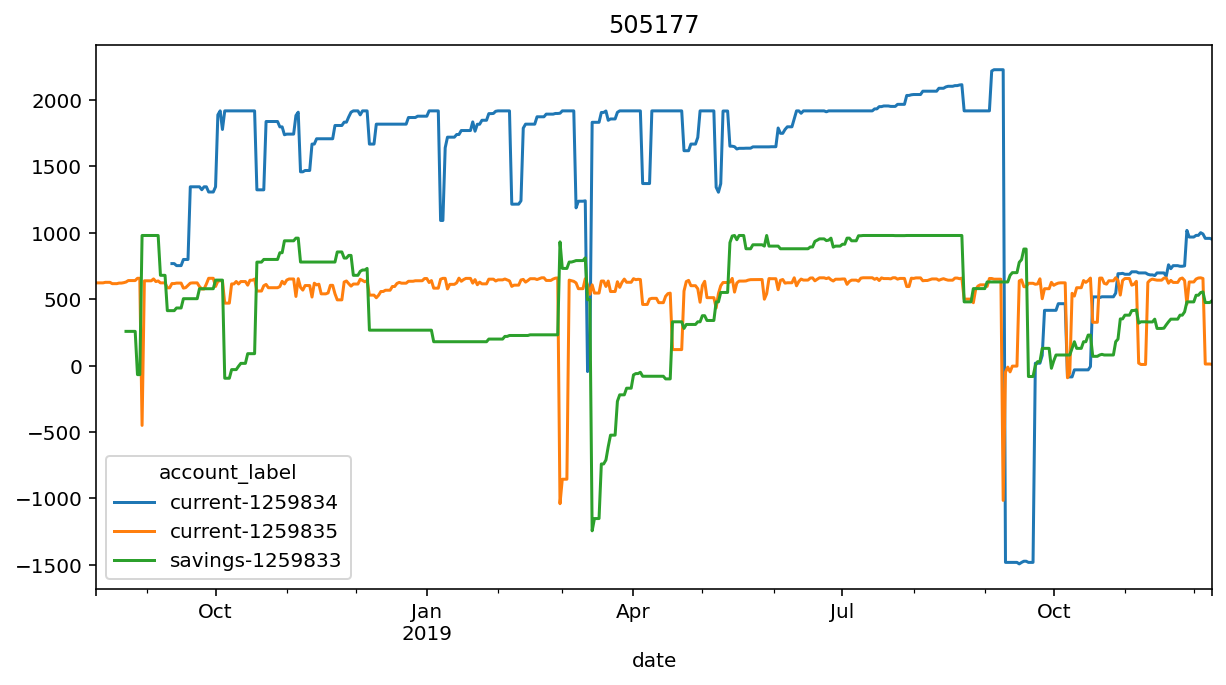

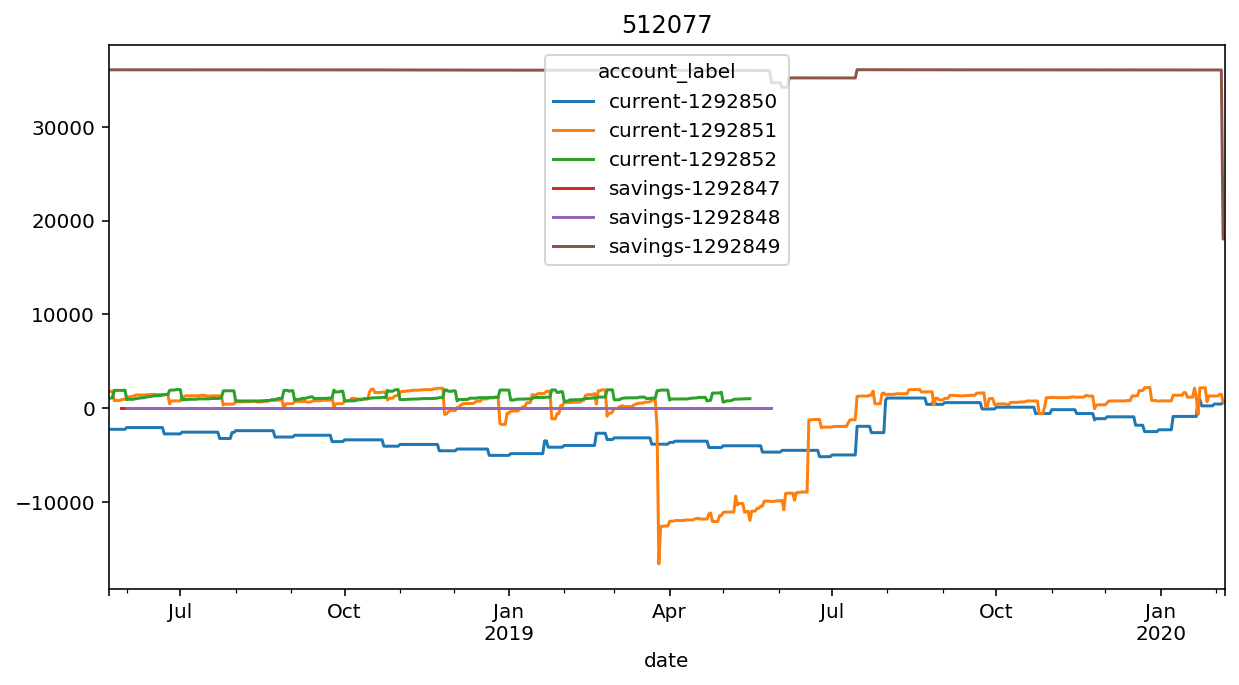

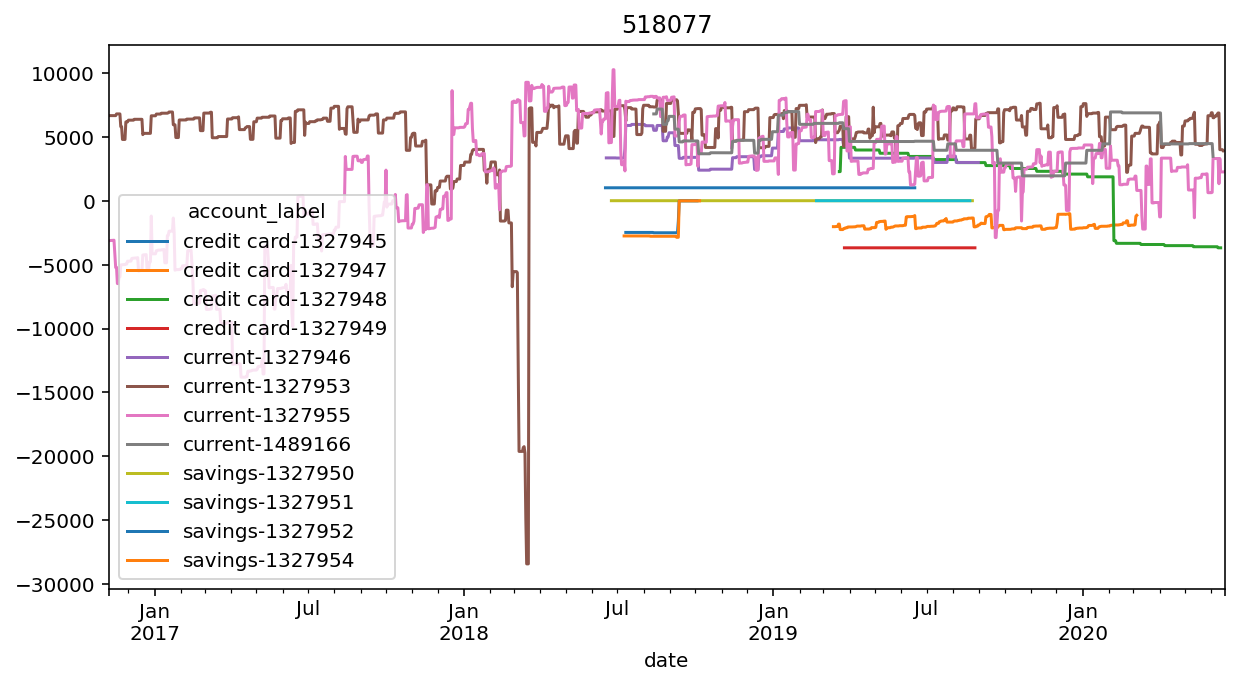

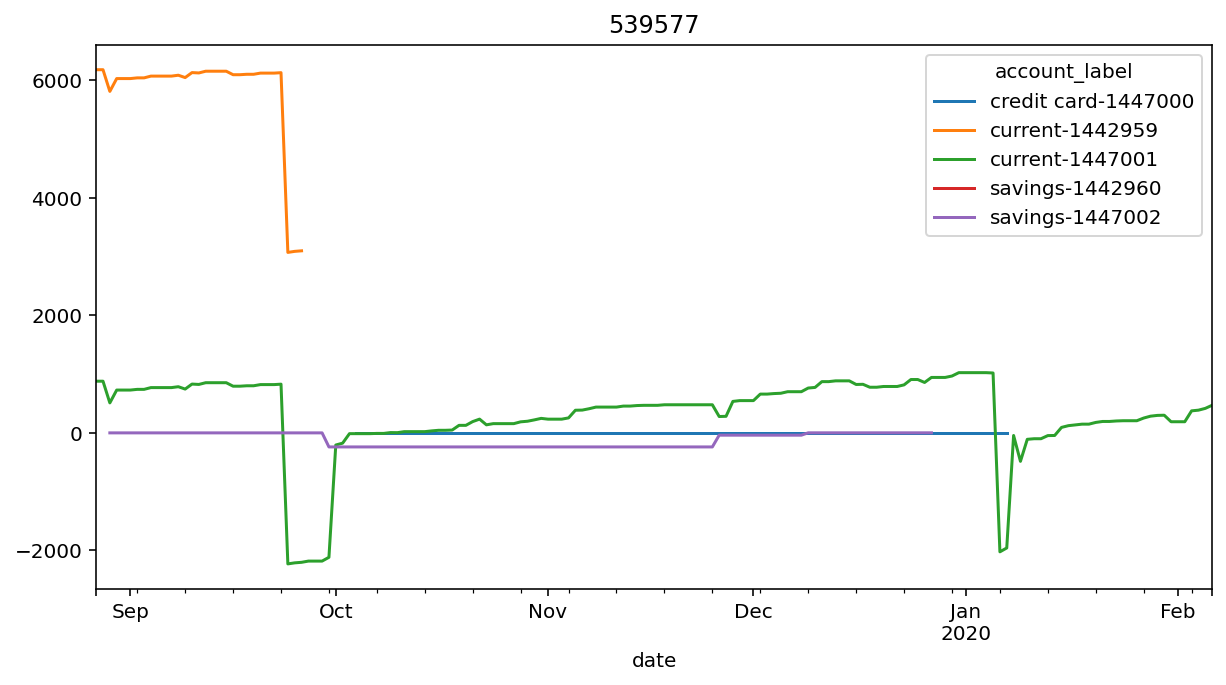

In [48]:
for id, data in daily_balances.groupby('user_id'):
    pivot = data.pivot_table('balance', 'date', 'account_label')
    if not pivot.empty:
        pivot.plot(figsize=(10, 5), title=id);